In [1]:
import numpy as np
import torch
import torch.optim as optim
from torch.distributions.bernoulli import Bernoulli
from utils import *

from causalml.inference.meta import BaseDRRegressor
from sklearn.linear_model import LinearRegression

import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns;sns.set()
from torch.optim import lr_scheduler 
from torch.nn import init 
import os 


# from tqdm.notebook import tqdm

/root/miniconda3/envs/myconda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def manipulation(u, v, n, card_u, model, c=0.05):
    v_target = v.repeat_interleave(torch.tensor([card_u]).repeat_interleave(n), dim=0)
    u_target = torch.eye(card_u).repeat(n, 1)
    x_target = torch.cat((u_target, v_target), dim=1)
    pi = model(x_target).view(-1, card_u)
    u_init = u.repeat_interleave(torch.tensor([card_u]).repeat_interleave(n), dim=0)
    _, u_init_category = torch.where(u_init == 1)
    _, u_taregt_category = torch.where(u_target == 1)
    cost = torch.abs(u_taregt_category - u_init_category).view(-1, card_u)
    inputs = torch.cat((v, pi), dim=1)
    utility = pi - c * cost
    index = utility.argmax(dim=1)
    u_shift = torch.zeros((n, card_u))
    u_shift[torch.arange(n), index] = 1
    return inputs, index.view(-1, 1), u_shift




def manipulation_soft(u, v, n, card_u, model):
    v_target = v.repeat_interleave(torch.tensor([card_u]).repeat_interleave(n), dim=0)
    u_target = torch.eye(card_u).repeat(n, 1)
    x_target = torch.cat((u_target, v_target), dim=1)
    pi = model(x_target).view(-1, card_u)
    u_init = u.repeat_interleave(torch.tensor([card_u]).repeat_interleave(n), dim=0)
    _, u_init_category = torch.where(u_init == 1)
    _, u_taregt_category = torch.where(u_target == 1)
    cost = torch.abs(u_taregt_category - u_init_category).view(-1, card_u)
    inputs = torch.cat((v, pi), dim=1)
    utility = pi - 0.05 * cost
    soft_utility = (torch.softmax(10 * utility, dim=1) ) # to strengthen the utility, otherwise it's near to random
    index = soft_utility.multinomial(num_samples = 1).reshape(-1)
    u_shift = torch.zeros((n, card_u))
    u_shift[torch.arange(n), index] = 1
    return inputs, index.view(-1, 1), u_shift



def allocation_policy(num_input, num_hidden):
    model = nn.Sequential(
        nn.Linear(num_input, num_hidden),
        nn.ReLU(),
        # nn.Linear(num_hidden, num_hidden),
        # nn.ReLU(),
        nn.Linear(num_hidden, 1),
        nn.Sigmoid()
    )
    return model



def shifted_distribution(num_input, num_hidden, num_strata):
    model = nn.Sequential(
        nn.Linear(num_input, num_hidden),
        nn.ReLU(),
        nn.Linear(num_hidden, num_hidden),
        nn.ReLU(),
        nn.Linear(num_hidden, num_strata)
    )
    return model

In [3]:
torch.set_default_dtype(torch.float32)
torch.set_default_device("cuda")

torch.manual_seed(1)

dim_v = 20
card_u = 5
beta = torch.tensor(list(np.linspace(-5, 5, card_u)) + list(np.random.normal(0, 1, size = (dim_v,))), dtype=torch.float32).view(-1, 1)
trans = torch.rand((dim_v, card_u), dtype=torch.float32)

H = 50
len_seq = 100
num_epoch = 300
T = 100
n = 5000
n_eval = 10000
repeat_num = 5

# fix samples for policy eval 
u_eval, v_eval = x_generate(n_eval, dim_v, trans, seed=0)

# generate sequential data (before manipulation)
seed_list = range(10)
dataset = {}
for s in seed_list:
    dataset[s] = [x_generate(n, dim_v, trans, seed=s) for i in range(T)]

In [4]:
# cutoff rule
def cutoff(seed, dim_v, card_u, beta, trans, n_eval, cost_coef=0.05):
    torch.set_default_dtype(torch.float32) 
    torch.set_default_device("cuda")    
    # global access u_eval, v_eval
    u_eval_shift = manipulation_cutoff(u_eval, v_eval, n_eval, card_u, beta, c=cost_coef)
    x_eval = torch.cat((u_eval_shift, v_eval), dim=1)
    tau_eval = x_eval @ beta
    pi_eval = torch.where(tau_eval > 0, torch.tensor(1), torch.tensor(0))
    value = torch.mean(pi_eval * tau_eval)
    return value.item()

In [5]:
init_u_list = []
mani_u_list = []


def VanillaGD(seed, dim_v, card_u, beta, trans, T, n, n_eval, lr_pi = 0.1, cost_coef=0.05):
    print(seed)
    torch.manual_seed(seed)
    np.random.seed(seed)
    torch.set_default_dtype(torch.float32) 
    torch.set_default_device("cuda")
    num_hiddens_pi = 2 * (dim_v + card_u)
    model_pi = allocation_policy(dim_v + card_u, num_hiddens_pi)
    
    cate_learner = BaseDRRegressor(learner=LinearRegression(), treatment_effect_learner=LinearRegression())    

    seq_revenue = []
    seq_x = []
    seq_z = []
    seq_y = []
    seq_pi = []
    optimizer_pi = optim.Adam(model_pi.parameters(), lr=lr_pi)    
    for t in range(T):
        u, v = dataset[seed][t]
        _, _, u_shift = manipulation(u, v, n, card_u, model_pi, c=cost_coef)
        init_u_list.append(u)
        mani_u_list.append(u_shift)

        # training of allocation policy
        x = torch.cat((u_shift, v), dim=1)
        pi = model_pi(x)
        z = Bernoulli(probs=pi).sample()
        y = y_generate(x, z, n, beta)

        seq_x.append(x)
        seq_z.append(z)
        seq_y.append(y)
        seq_pi.append(pi)
        
        cate_fit(seq_x, seq_y, seq_z, seq_pi, cate_learner)
        tau = cate_predict(x, pi, cate_learner).cuda()        

        # cate_fit(seq_x, seq_y, seq_z, seq_pi, cate_learner)
#         tau = x @ beta
        # tau = cate_predict(x, pi, cate_learner)
        # rwd_mean = torch.mean(tau.detach())
        # revenue = - torch.mean(pi * (tau.detach() - rwd_mean))
        revenue = - torch.mean(pi * (tau.detach()))

        optimizer_pi.zero_grad()
        revenue.backward()
        optimizer_pi.step()

        # evaluation of allocation policy
        _, _, u_eval_shift = manipulation(u_eval, v_eval, n_eval, card_u, model_pi)

        x_eval = torch.cat((u_eval_shift, v_eval), dim=1)
        pi_eval = model_pi(x_eval)
        tau_eval = x_eval @ beta
        value = torch.mean(pi_eval * tau_eval)

        seq_revenue.append(value.item())
        
    if seed == 0:
        torch.save(model_pi, "models/vani_model_pi_cc_{}.pkl".format(cost_coef))

    
    return seq_revenue

In [12]:

def End2endGD(seed, dim_v, card_u, beta, trans, H, f, len_seq, num_epoch, T, n, n_eval, lr_pi = 0.1, lr_prob = 0.05, cost_coef=0.05):
    print(seed)
    torch.set_default_dtype(torch.float32) 
    torch.set_default_device("cuda")
    torch.manual_seed(seed)
    np.random.seed(seed)
    num_hiddens_pi = 2 * (dim_v + card_u)
    model_pi = allocation_policy(dim_v + card_u, num_hiddens_pi)
    
    dim_theta = nn.utils.parameters_to_vector(model_pi.parameters()).detach().shape[0]
    num_hiddens_prob = 2 * (dim_v + dim_theta)
    model_prob = shifted_distribution(dim_v + dim_theta, num_hiddens_prob, card_u)
    patience = 2

    cate_learner = BaseDRRegressor(learner=LinearRegression(), treatment_effect_learner=LinearRegression())
    
    stop_flag = 0
    t = 0
    seq_revenue = []
    seq_loss = []
    seq_val = []
    seq_inputs_for_behavior = []
    # seq_inputs_for_policy = []
    seq_category = []
    seq_x = []
    seq_z = []
    seq_y = []
    seq_pi = []
    
    optimizer_pi = optim.Adam(model_pi.parameters(), lr=lr_pi)
    
    for t in range(H):
        u, v = dataset[seed][t]
        inputs_for_behavior, inputs_for_policy, u_category, u_shift = manipulation_theta(u, v, n, card_u, model_pi, c=cost_coef)

        # seq_inputs.append(inputs.detach())
        seq_inputs_for_behavior.append(inputs_for_behavior)
        # seq_inputs_for_policy.append(inputs_for_policy)
        seq_category.append(u_category)

        if len(seq_inputs_for_behavior) > len_seq:
            seq_inputs_for_behavior.pop(0)
            # seq_inputs_for_policy.pop(0)            
            seq_category.pop(0)

        # training of allocation policy
        x = torch.cat((u_shift, v), dim=1)
        pi = model_pi(x)
        z = Bernoulli(probs=pi).sample()
        y = y_generate(x, z, n, beta)

        seq_x.append(x)
        seq_z.append(z)
        seq_y.append(y)
        seq_pi.append(pi)

        cate_fit(seq_x, seq_y, seq_z, seq_pi, cate_learner)
        tau = cate_predict(x, pi, cate_learner).cuda()
        # tau = (x @ beta)

        
        revenue = - torch.mean(pi * tau.detach())
        optimizer_pi.zero_grad()
        revenue.backward()
        optimizer_pi.step()

        # evaluation of allocation policy
        _, _, _, u_eval_shift = manipulation_theta(u_eval, v_eval, n_eval, card_u, model_pi, c=cost_coef)

        x_eval = torch.cat((u_eval_shift, v_eval), dim=1)
        pi_eval = model_pi(x_eval)
        tau_eval = x_eval @ beta
        value = torch.mean(pi_eval * tau_eval)

        seq_revenue.append(value.item())

    # training of the shifted distribution
    # stacked_inputs_for_policy = torch.cat(seq_inputs_for_policy, dim=0)
    stacked_inputs = torch.cat(seq_inputs_for_behavior, dim=0)    
    stacked_category = torch.cat(seq_category, dim=0)

    random_indices = torch.randperm(stacked_inputs.shape[0])
    stacked_inputs = stacked_inputs[random_indices]
    stacked_category = stacked_category[random_indices]

    n_sample = int(stacked_inputs.shape[0] * 0.8)

    # notice that we use detach theta inputs for behavior model
    train_inputs = stacked_inputs[0:n_sample, :]
    train_category = stacked_category[0:n_sample, :]
    val_inputs = stacked_inputs[n_sample:, :]
    val_category = stacked_category[n_sample:, :]

    early_stop_counter = 0
    best_val_loss = float('inf')

    loss_function = nn.CrossEntropyLoss()
    optimizer_prob = optim.SGD(model_prob.parameters(), lr=lr_prob)
    for epoch in range(num_epoch):
        loss = loss_function(model_prob(train_inputs), train_category.view(-1))
        optimizer_prob.zero_grad()
        loss.backward()
        optimizer_prob.step()
        seq_loss.append(loss.item())

        loss_val = loss_function(model_prob(val_inputs), val_category.view(-1))
        seq_val.append(loss_val.item())

        if loss_val < best_val_loss:
            best_val_loss = loss_val
            early_stop_counter = 0
        else:
            early_stop_counter += 1

        if early_stop_counter >= patience:
            break

    optimizer_pi = optim.SGD(model_pi.parameters(), lr=lr_pi)     
    pi_lr_sch = lr_scheduler.StepLR(optimizer_pi, step_size = 100, gamma = 0.6)
    
    while True:
        t = t + 1
        u, v = dataset[seed][t]
        # inputs, u_category, u_shift = manipulation_theta(u, v, n, card_u, model_pi)
        inputs_for_behavior, inputs_for_policy, u_category, u_shift = manipulation_theta(u, v, n, card_u, model_pi, c=cost_coef)

        # seq_inputs.append(inputs.detach())
        seq_inputs_for_behavior.append(inputs_for_behavior)
        # seq_inputs_for_policy.append(inputs_for_policy)
                
        seq_category.append(u_category)

        if len(seq_inputs_for_behavior) > len_seq:
            seq_inputs_for_behavior.pop(0)        
            seq_category.pop(0)

        # training of allocation policy
        x = torch.cat((u_shift, v), dim=1)
        pi = model_pi(x)
        z = Bernoulli(probs=pi).sample()
        y = y_generate(x, z, n, beta)

        seq_x.append(x)
        seq_z.append(z)
        seq_y.append(y)
        seq_pi.append(pi)

        tau = cate_predict(x, pi, cate_learner).cuda()
#         tau = x @ beta
        log_prob = nn.LogSoftmax(dim=1)(model_prob(inputs_for_policy))[torch.arange(n), u_category.view(-1)]

        revenue = - torch.mean(pi * tau) - torch.mean(pi.detach() * tau * log_prob)        
        optimizer_pi.zero_grad()
        revenue.backward()
        optimizer_pi.step()

        # evaluation of allocation policy
        _, _, _, u_eval_shift = manipulation_theta(u_eval, v_eval, n_eval, card_u, model_pi, c=cost_coef)

        x_eval = torch.cat((u_eval_shift, v_eval), dim=1)
        pi_eval = model_pi(x_eval)
        tau_eval = x_eval @ beta
        value = torch.mean(pi_eval * tau_eval)

        seq_revenue.append(value.item())



        if (t - H + 1) % f == 0 and not stop_flag:
            # estimation of cate
            cate_fit(seq_x, seq_y, seq_z, seq_pi, cate_learner)            

            # training of the shifted distribution
            stacked_inputs = torch.cat(seq_inputs_for_behavior, dim=0)
            stacked_category = torch.cat(seq_category, dim=0)

            random_indices = torch.randperm(stacked_inputs.shape[0])
            stacked_inputs = stacked_inputs[random_indices]
            stacked_category = stacked_category[random_indices]

            n_sample = int(stacked_inputs.shape[0] * 0.8)

            train_inputs = stacked_inputs[0:n_sample, :]
            train_category = stacked_category[0:n_sample, :]
            val_inputs = stacked_inputs[n_sample:, :]
            val_category = stacked_category[n_sample:, :]

            early_stop_counter = 0
            # best_val_loss = float('inf')

            loss_function = nn.CrossEntropyLoss()
            optimizer_prob = optim.SGD(model_prob.parameters(), lr=lr_prob)
            for epoch in range(num_epoch//2):
                loss = loss_function(model_prob(train_inputs), train_category.view(-1))
                optimizer_prob.zero_grad()
                loss.backward()
                optimizer_prob.step()
                seq_loss.append(loss.item())

                loss_val = loss_function(model_prob(val_inputs), val_category.view(-1))
                seq_val.append(loss_val.item())

                if loss_val < best_val_loss:
                    best_val_loss = loss_val
                    early_stop_counter = 0
                    
                else:
                    early_stop_counter += 1

                if early_stop_counter >= patience:
                    break
            
            seq_inputs_for_behavior = seq_inputs_for_behavior[-f*n:]
            seq_category = seq_category[-f*n:]

        if t >= T - 1:
            break
    
    plt.figure(figsize=(16,6))
    plt.subplot(1, 2, 1)
    plt.plot(seq_revenue)

    plt.subplot(1, 2, 2)
    plt.plot(seq_loss, label='loss')
    plt.plot(seq_val, label='val')
    plt.legend()
    plt.savefig("learn_curve/learn_end2end_seed{}_card{}.pdf".format(seed, card_u))    
    plt.show()   
    
    if seed == 0:
        torch.save([seq_revenue, seq_loss, seq_val], "train_curve_e2e.pkl")        
        torch.save(model_pi, "models/e2e_model_pi_cc_{}.pkl".format(cost_coef))
        torch.save(model_prob, "models/e2e_model_prob_cc_{}.pkl".format(cost_coef))            

    return seq_revenue

In [11]:
mani_u_list_mm = []


def StrategicGD(seed, dim_v, card_u, beta, trans, H, f, len_seq, num_epoch, T, n, n_eval, lr_pi = 0.01, lr_prob = 0.01, cost_coef = 0.05):
    print(seed)
    torch.set_default_dtype(torch.float32) 
    torch.set_default_device("cuda")
    
#     torch.manual_seed(1000)
#     u_eval, v_eval = x_generate(n_eval, dim_v, trans)

    # torch.manual_seed(seed)
    torch.manual_seed(seed)
    np.random.seed(seed)

    num_hiddens_pi = 2 * (dim_v + card_u)
    model_pi = allocation_policy(dim_v + card_u, num_hiddens_pi)
    # lr_pi = 0.002

    num_hiddens_prob = 2 * (dim_v + card_u)
    model_prob = shifted_distribution(card_u, num_hiddens_prob, card_u)
    
#     model_prob = shifted_distribution(dim_v + 2 * card_u, num_hiddens_prob, card_u)

    patience = 3

    cate_learner = BaseDRRegressor(learner=LinearRegression(), treatment_effect_learner=LinearRegression())

    # flag for stopping CATE and h_gamma when validation loss is low enough
    stop_flag = 0
    converge_flag = 0
    
    t = 0
    seq_revenue = []
    seq_loss = []
    seq_val = []
    seq_inputs = []
    seq_category = []
    seq_x = []
    seq_z = []
    seq_y = []
    seq_pi = []
    
    optimizer_pi = optim.Adam(model_pi.parameters(), lr=lr_pi)    
    
    
    for t in range(H):
        u, v = dataset[seed][t]

        inputs, u_category, u_shift = manipulation(u, v, n, card_u, model_pi, c=cost_coef)
        
#         inputs = torch.cat([inputs, u], dim=1) # add original u into input
        
        mani_u_list_mm.append(u_shift)
            
        # training of allocation policy
        x = torch.cat((u_shift, v), dim=1)
        
        
        # with torch.no_grad():
        pi = model_pi(x) 
        # pi = model_pi(x) 
        z = Bernoulli(probs=pi).sample()
        y = y_generate(x, z, n, beta, seed=seed)
        
        # inputs = torch.cat([u, inputs], dim=1)
        inputs = inputs[:,-card_u:] # only need zeta as input
        
        
        seq_inputs.append(inputs.detach())
        seq_category.append(u_category)
        seq_x.append(x)
        seq_z.append(z)
        seq_y.append(y)
        seq_pi.append(pi)

        cate_fit(seq_x, seq_y, seq_z, seq_pi, cate_learner)
        tau = cate_predict(x, pi, cate_learner).cuda()    
        # tau = x @ beta    

        # for _ in range(5):  
            # pi = model_pi(x)            
        revenue = - torch.mean(pi * tau.detach())
        optimizer_pi.zero_grad()
        revenue.backward()
        optimizer_pi.step()

        # evaluation of allocation policy    

        _, _, u_eval_shift = manipulation(u_eval, v_eval, n_eval, card_u, model_pi, c=cost_coef)
        x_eval = torch.cat((u_eval_shift, v_eval), dim=1)
        pi_eval = model_pi(x_eval)
        tau_eval = x_eval @ beta
        value = torch.mean(pi_eval * tau_eval)
        seq_revenue.append(value.item())

    # training of the shifted distribution
    stacked_inputs = torch.cat(seq_inputs, dim=0)
    stacked_category = torch.cat(seq_category, dim=0)

    random_indices = torch.randperm(stacked_inputs.shape[0])
    stacked_inputs = stacked_inputs[random_indices]
    stacked_category = stacked_category[random_indices]

    n_sample = int(stacked_inputs.shape[0] * 0.8)

    train_inputs = stacked_inputs[0:n_sample, :]
    train_category = stacked_category[0:n_sample, :]
    val_inputs = stacked_inputs[n_sample:, :]
    val_category = stacked_category[n_sample:, :]

    early_stop_counter = 0
    best_val_loss = float('inf')

    loss_function = nn.CrossEntropyLoss()
    # optimizer_prob = optim.Adam(model_prob.parameters(), lr=lr_prob)
    optimizer_prob = optim.SGD(model_prob.parameters(), lr=lr_prob)
    
    for epoch in range(num_epoch):
        loss = loss_function(model_prob(train_inputs), train_category.view(-1))
        optimizer_prob.zero_grad()
        loss.backward()
        optimizer_prob.step()
        seq_loss.append(loss.item())
        loss_val = loss_function(model_prob(val_inputs), val_category.view(-1))
        seq_val.append(loss_val.item())
        if loss_val < best_val_loss:
            best_val_loss = loss_val
            early_stop_counter = 0
        else:
            early_stop_counter += 1

        if early_stop_counter >= patience:
            break

    print("Final Training Loss: %.3f"%loss_val.item())
    print("Epoch: %d"%epoch)
    
    optimizer_pi = optim.Adagrad(model_pi.parameters(), lr=lr_pi)     
    
    while True:
        t = t + 1
        u, v = dataset[seed][t]
        inputs, u_category, u_shift = manipulation(u, v, n, card_u, model_pi, c=cost_coef)  
#         inputs = torch.cat([inputs, u], dim=1) # add original u into input            
        inputs = inputs[:,-card_u:]      
        
        # record u after manipulation
        mani_u_list_mm.append(u_shift)                
        seq_inputs.append(inputs.detach())
        seq_category.append(u_category)

        if len(seq_inputs) > len_seq:
            seq_inputs.pop(0)
            seq_category.pop(0)

        # train model pi
        x = torch.cat((u_shift, v), dim=1)        
        z = Bernoulli(probs=pi).sample()
        y = y_generate(x, z, n, beta, seed=seed)
        seq_x.append(x)
        seq_z.append(z)
        seq_y.append(y)
        pi = model_pi(x)  
        seq_pi.append(pi) 
        
        log_prob = nn.LogSoftmax(dim=1)(model_prob(inputs))[torch.arange(n), u_category.view(-1)]              
        tau = cate_predict(x, pi, cate_learner).cuda()     
        revenue = - torch.mean(pi * tau) -  torch.mean(pi.detach() * tau * log_prob)            
        optimizer_pi.zero_grad()
        revenue.backward(retain_graph=True)        
                
        optimizer_pi.step()

        # evaluation of allocation policy
        _, _, u_eval_shift = manipulation(u_eval, v_eval, n_eval, card_u, model_pi, c=cost_coef)
        x_eval = torch.cat((u_eval_shift, v_eval), dim=1)
        pi_eval = model_pi(x_eval)
        tau_eval = x_eval @ beta
        value = torch.mean(pi_eval * tau_eval)
        seq_revenue.append(value.item())

        if seq_revenue[-1] > 5:
            converge_flag = 1
        if seq_revenue[-1] < 5 and converge_flag == 1:
            print("break converge at epoch {}".format(t))
            converge_flag = 0

        if t >= T - 1:
            break
            
    plt.figure(figsize=(16,6))
    plt.subplot(1, 2, 1)
    plt.plot(seq_revenue)

    plt.subplot(1, 2, 2)
    plt.plot(seq_loss, label='train loss')
    plt.plot(seq_val, label='val loss')
    plt.legend()
    # plt.savefig("learn_curve/learn_strategic_seed{}_card{}.pdf".format(seed, card_u))
    plt.show()
    
    if seed == 0:
        torch.save([seq_revenue, seq_loss, seq_val], "train_curve_spg.pkl")
        torch.save(model_pi, "models/model_pi_cc_{}.pkl".format(cost_coef))
        torch.save(model_prob, "models/model_prob_cc_{}.pkl".format(cost_coef))            

    return seq_revenue


0.15
0
Final Training Loss: 1.312
Epoch: 299


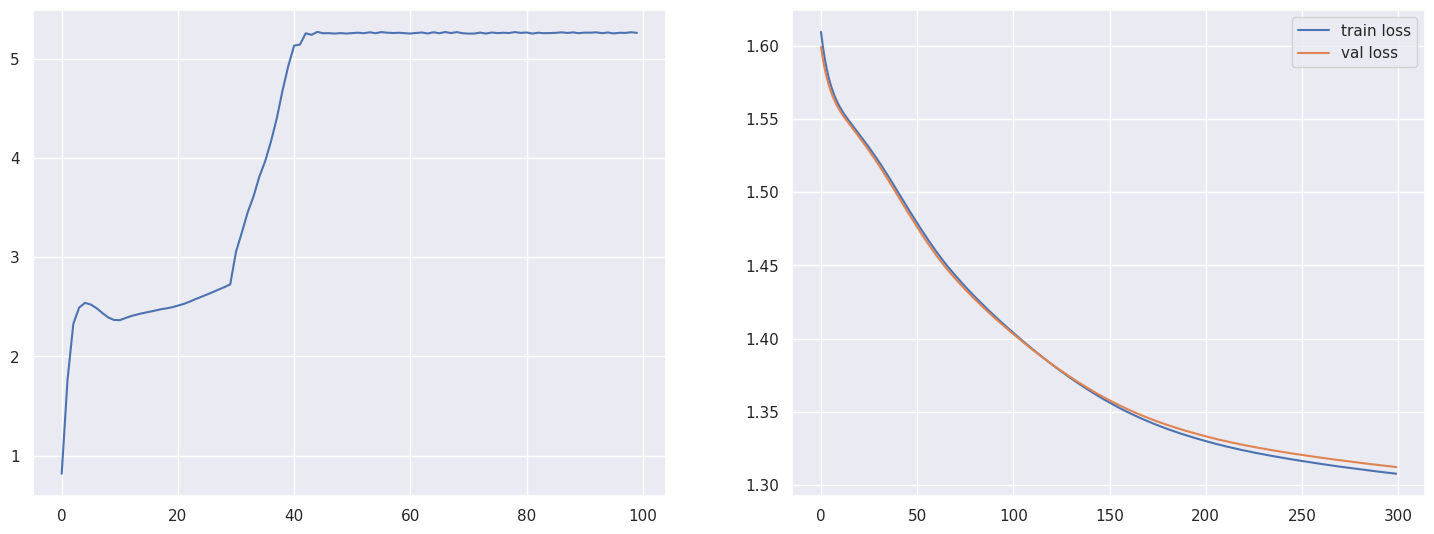

0


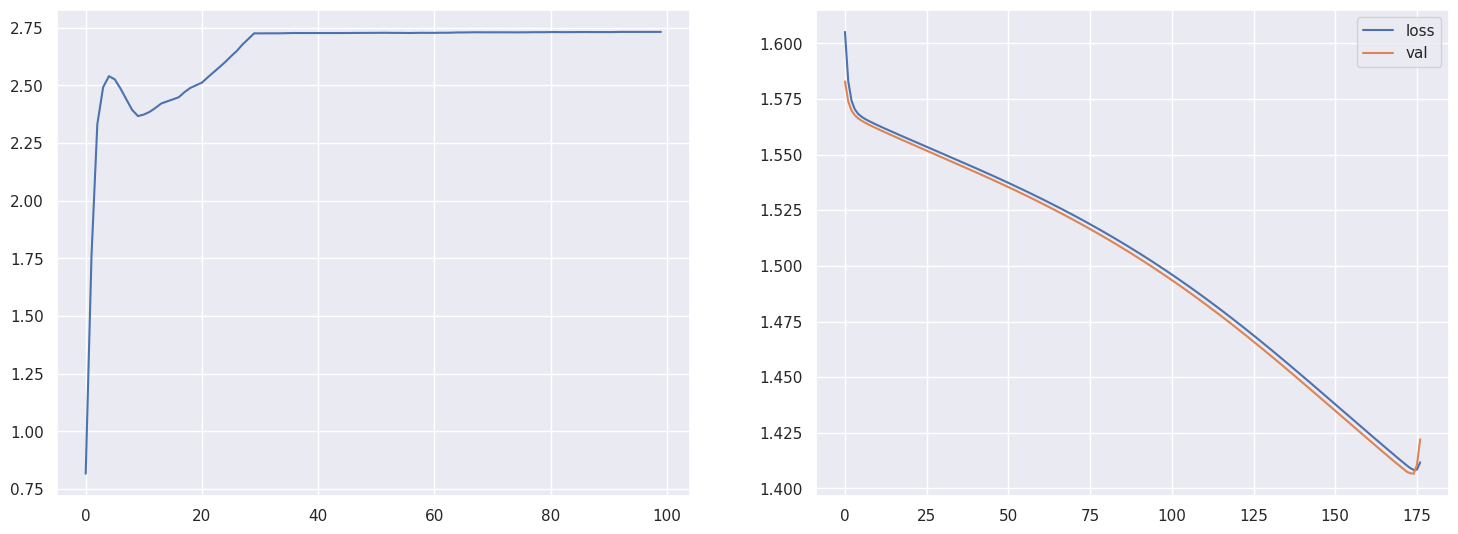

0
1
Final Training Loss: 1.253
Epoch: 299


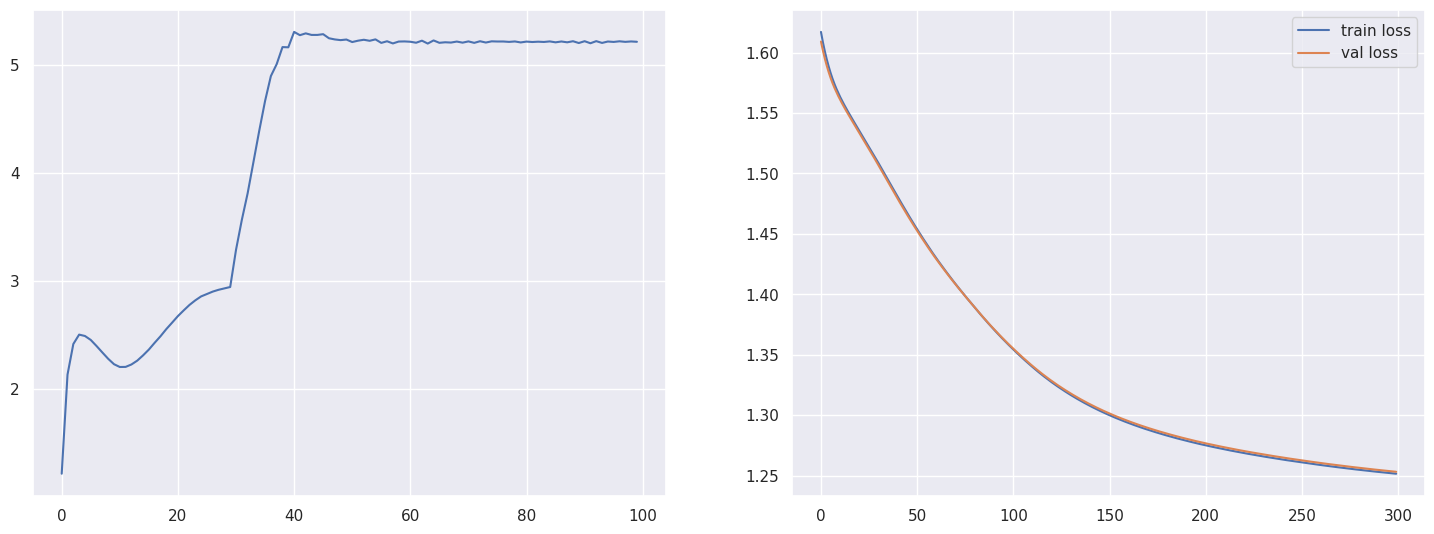

1


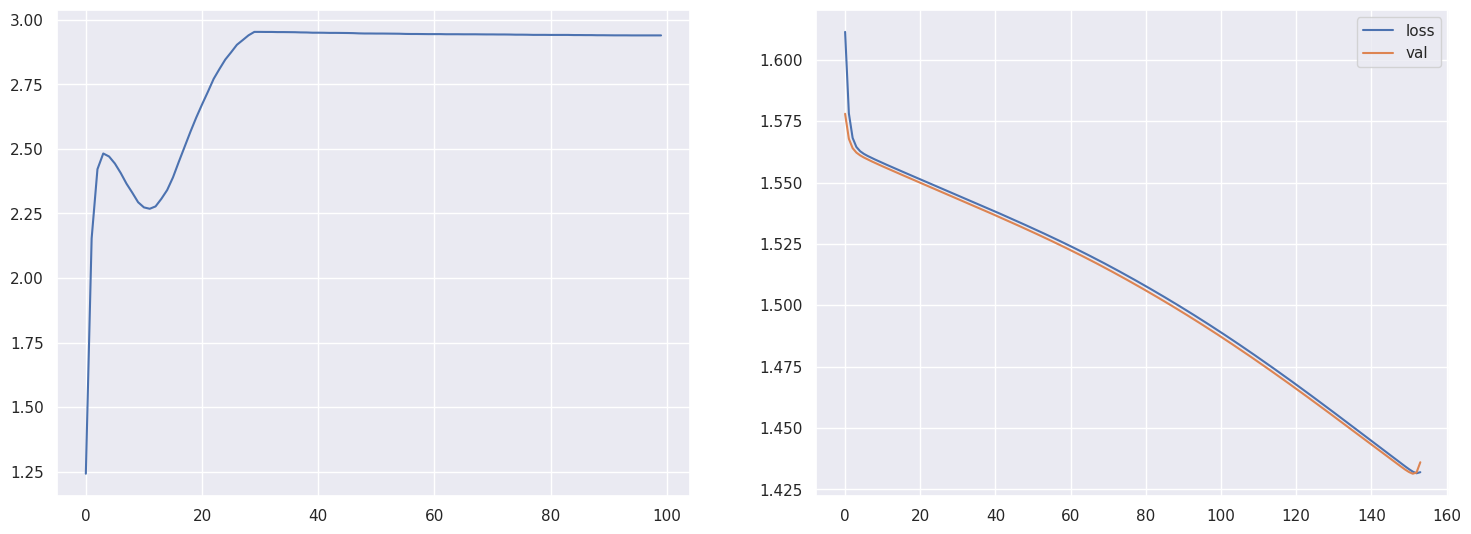

1
2
Final Training Loss: 1.274
Epoch: 299
break converge at epoch 42
break converge at epoch 46
break converge at epoch 52
break converge at epoch 54
break converge at epoch 62
break converge at epoch 68
break converge at epoch 93


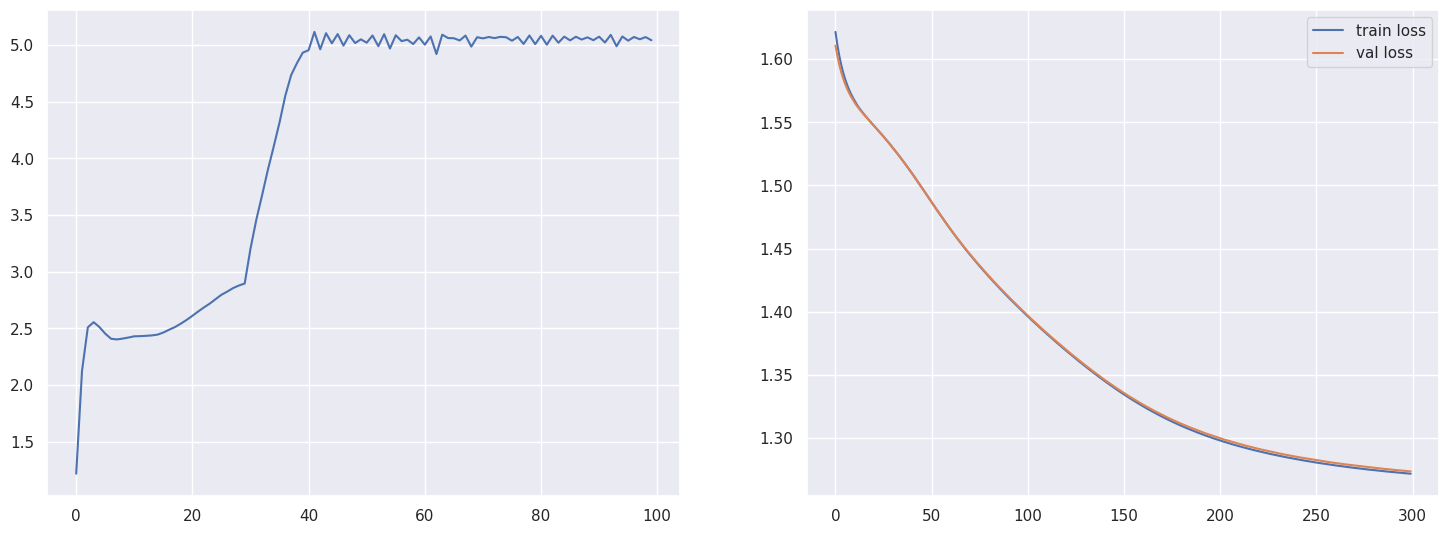

2


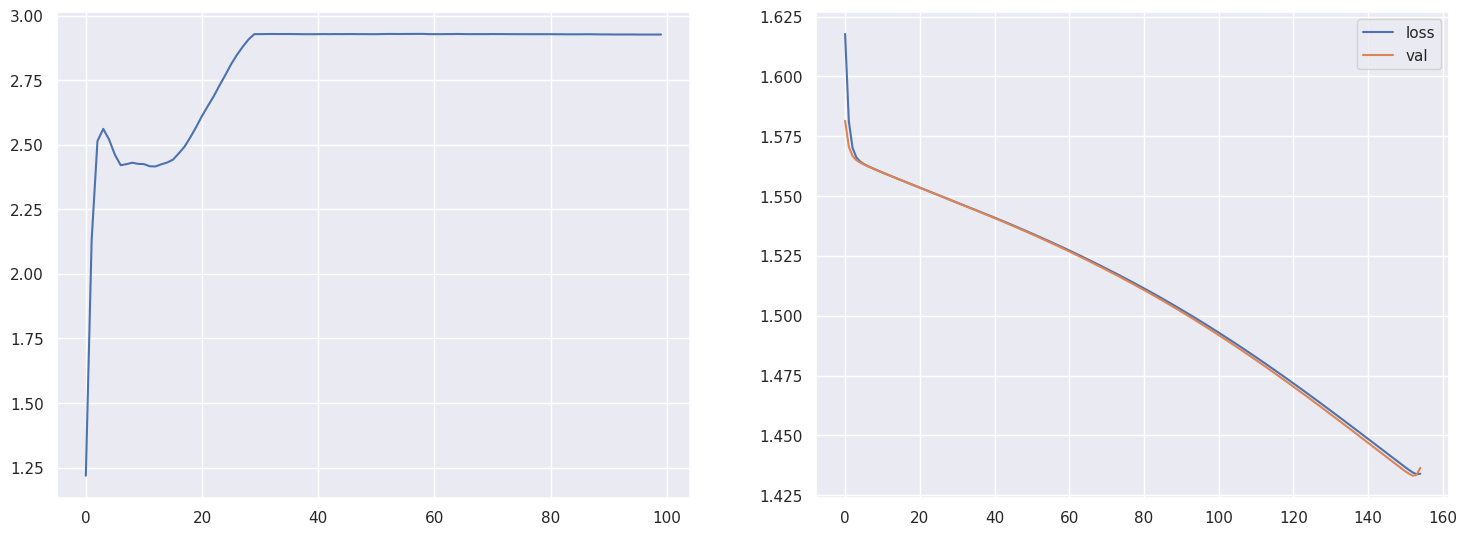

2
3
Final Training Loss: 1.276
Epoch: 299


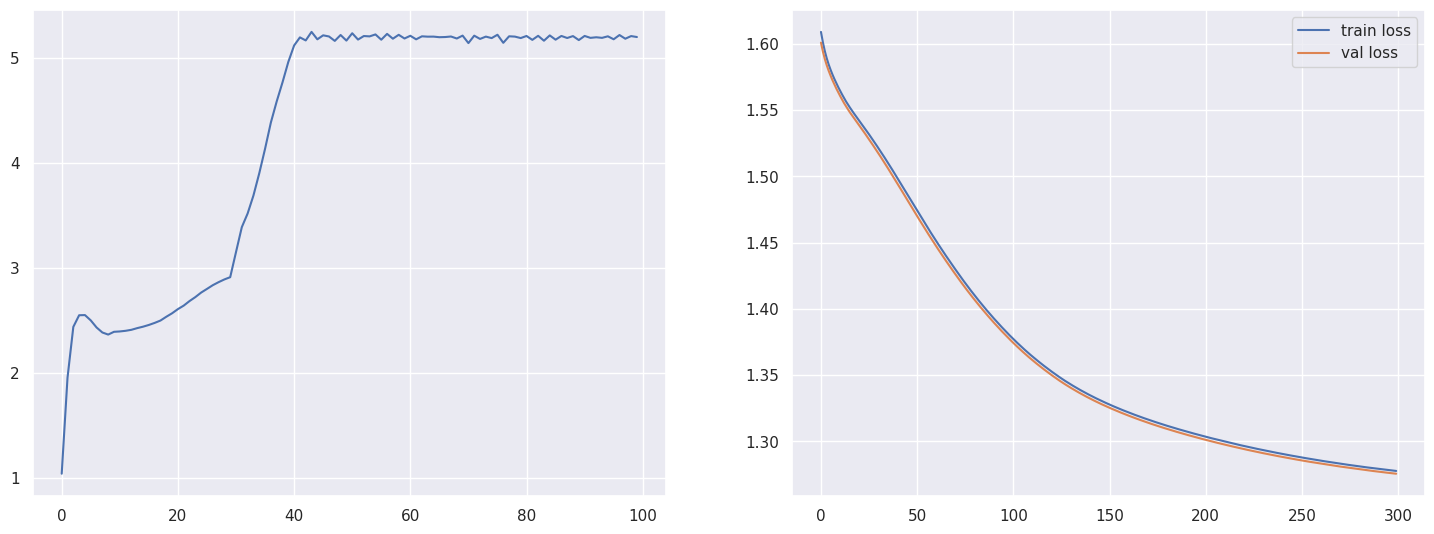

3


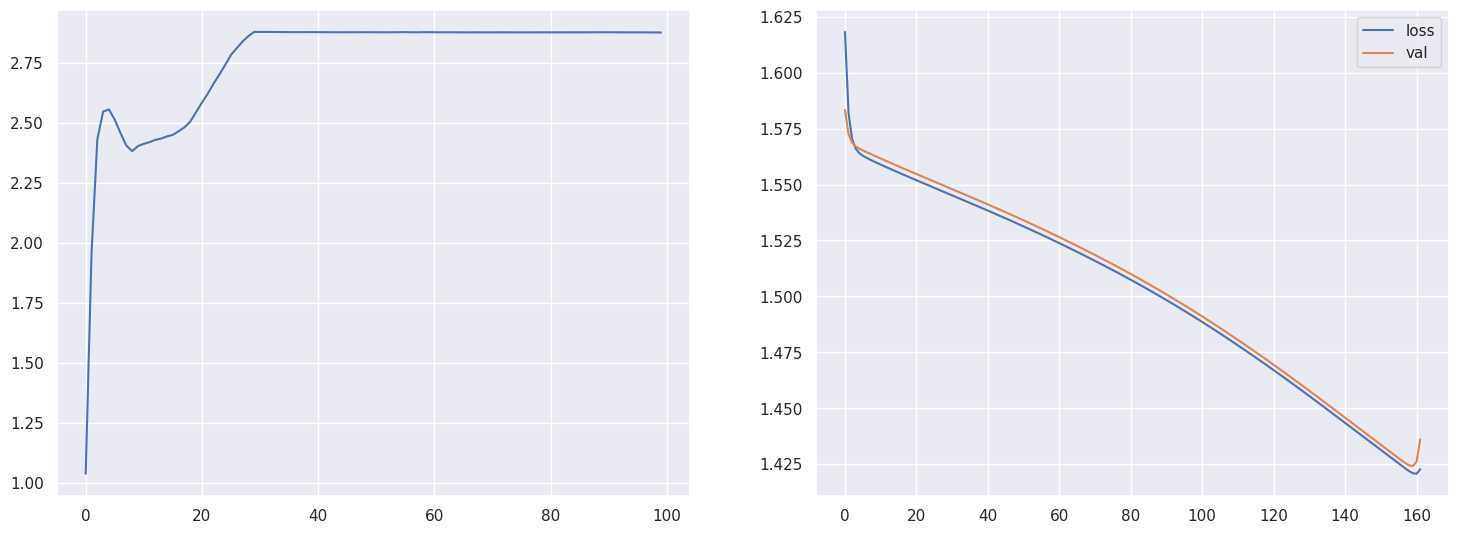

3
4
Final Training Loss: 1.274
Epoch: 248


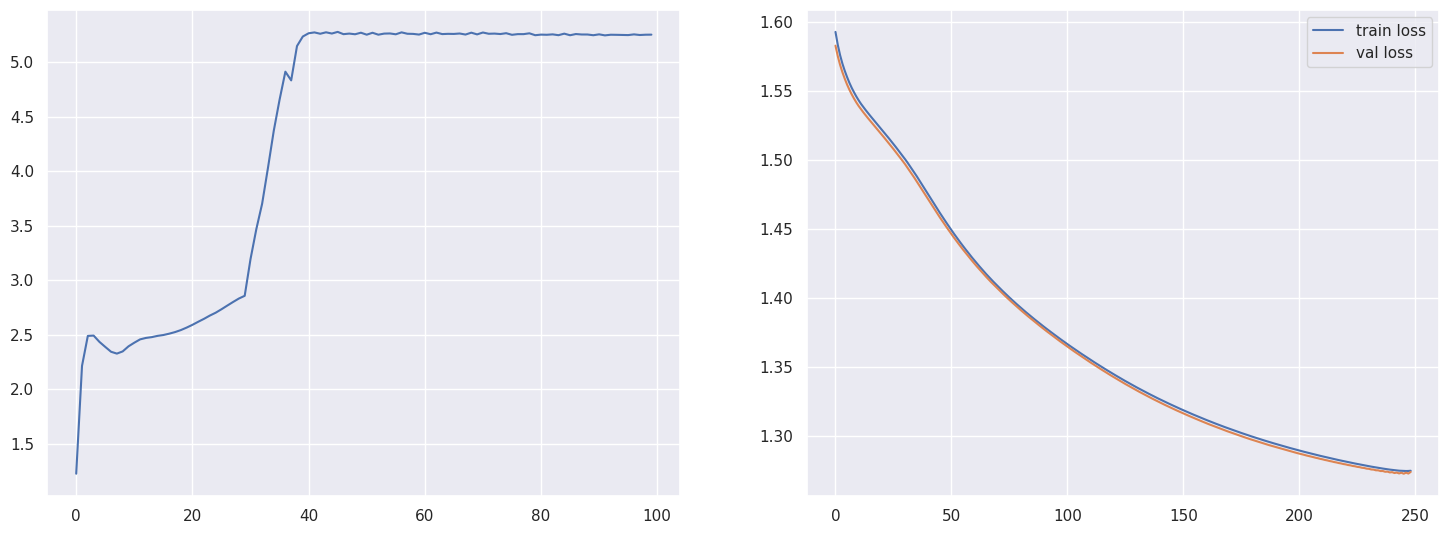

4


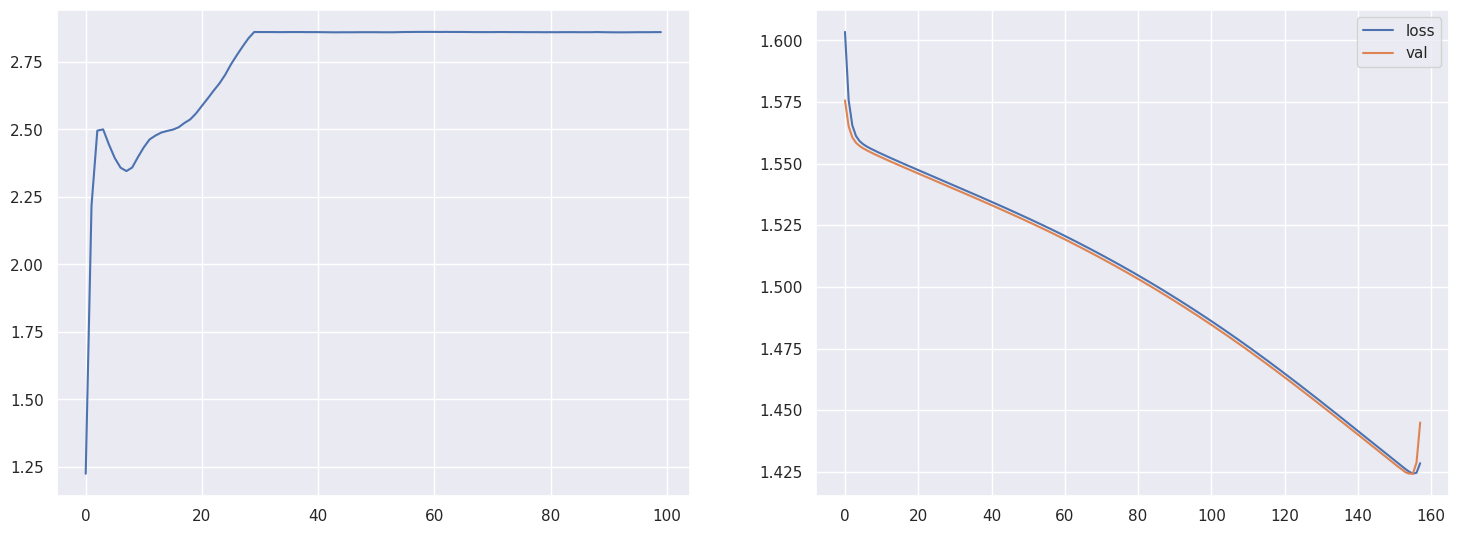

4
5
Final Training Loss: 1.306
Epoch: 299


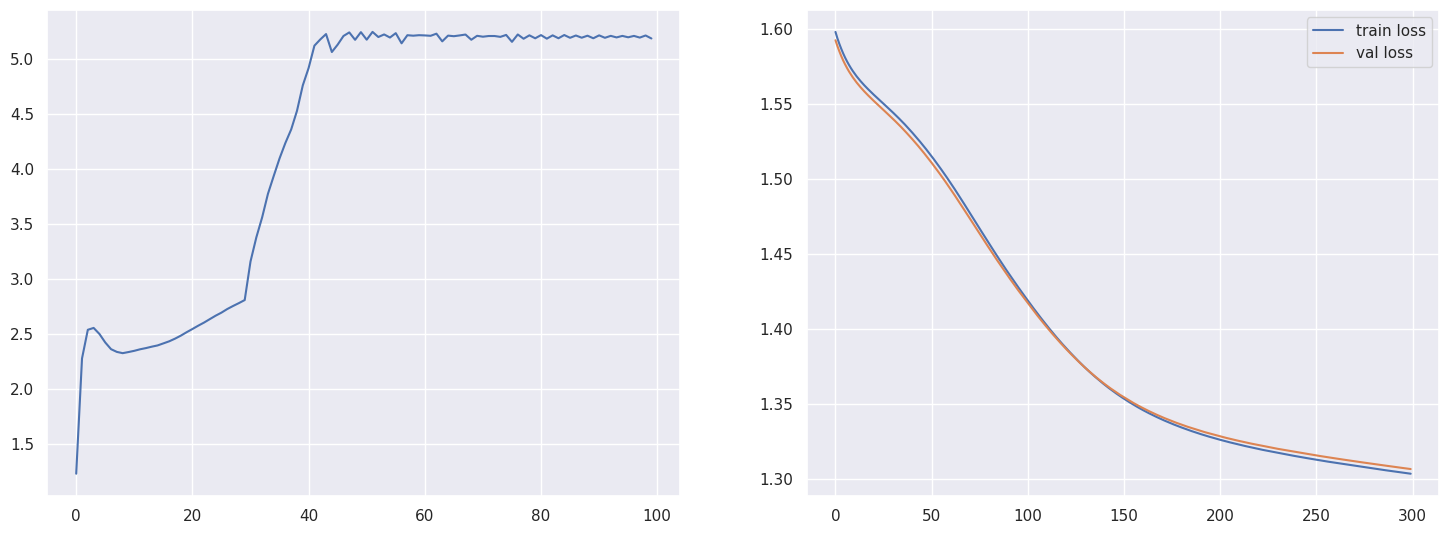

5


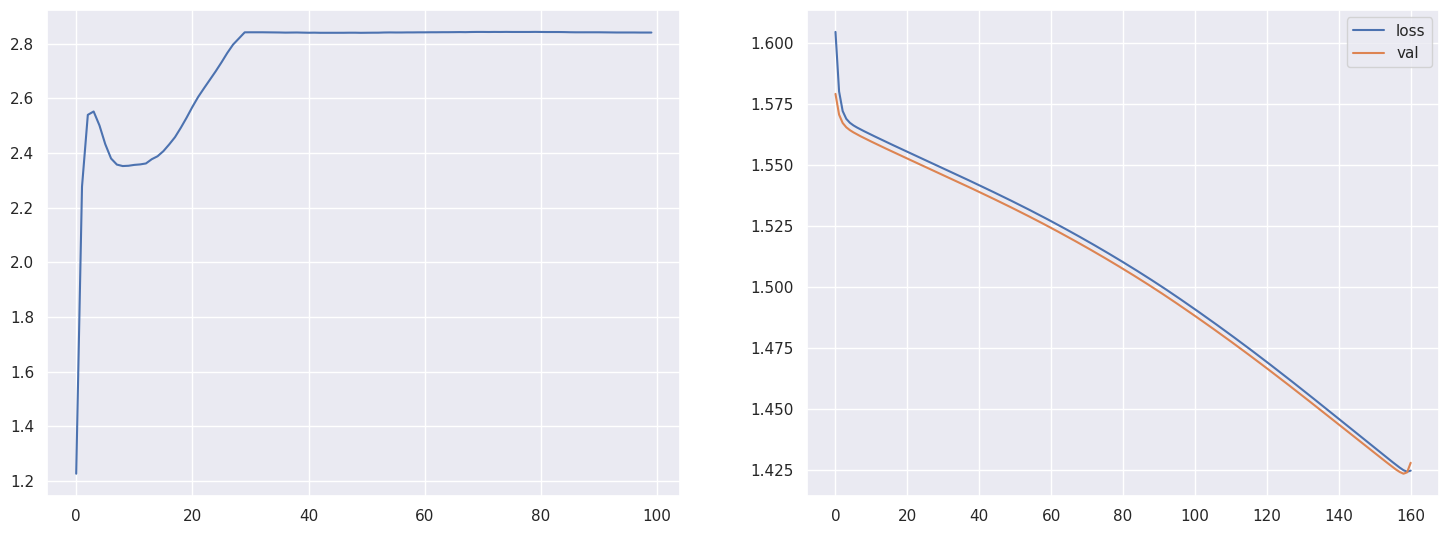

5
6
Final Training Loss: 1.272
Epoch: 299


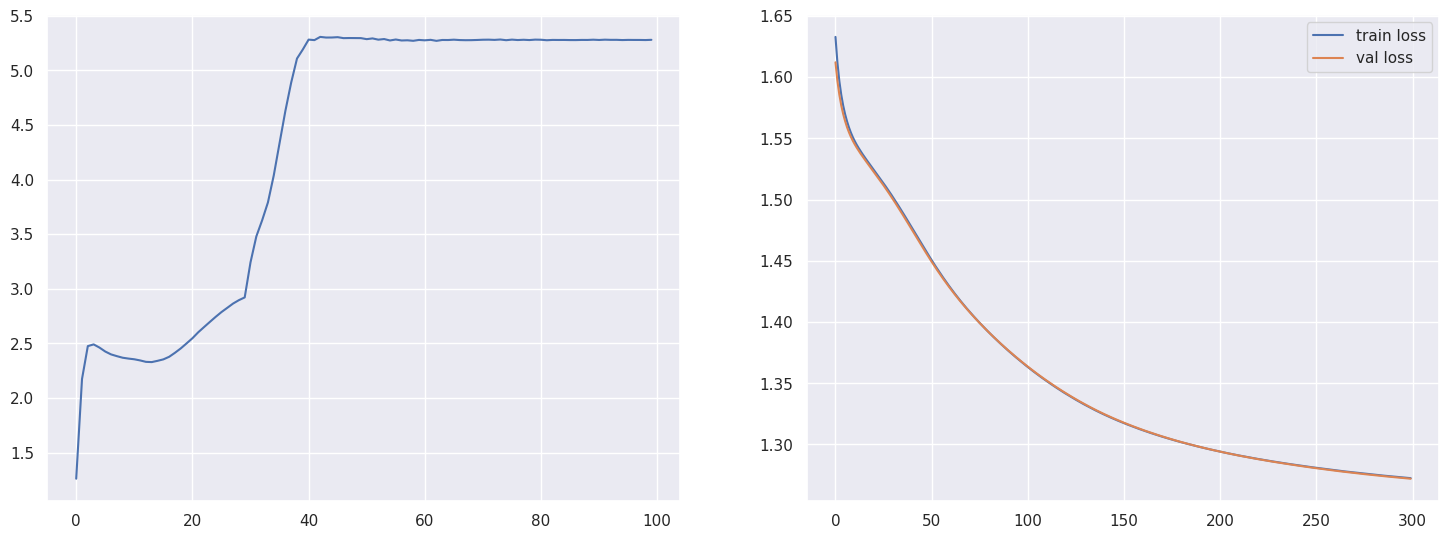

6


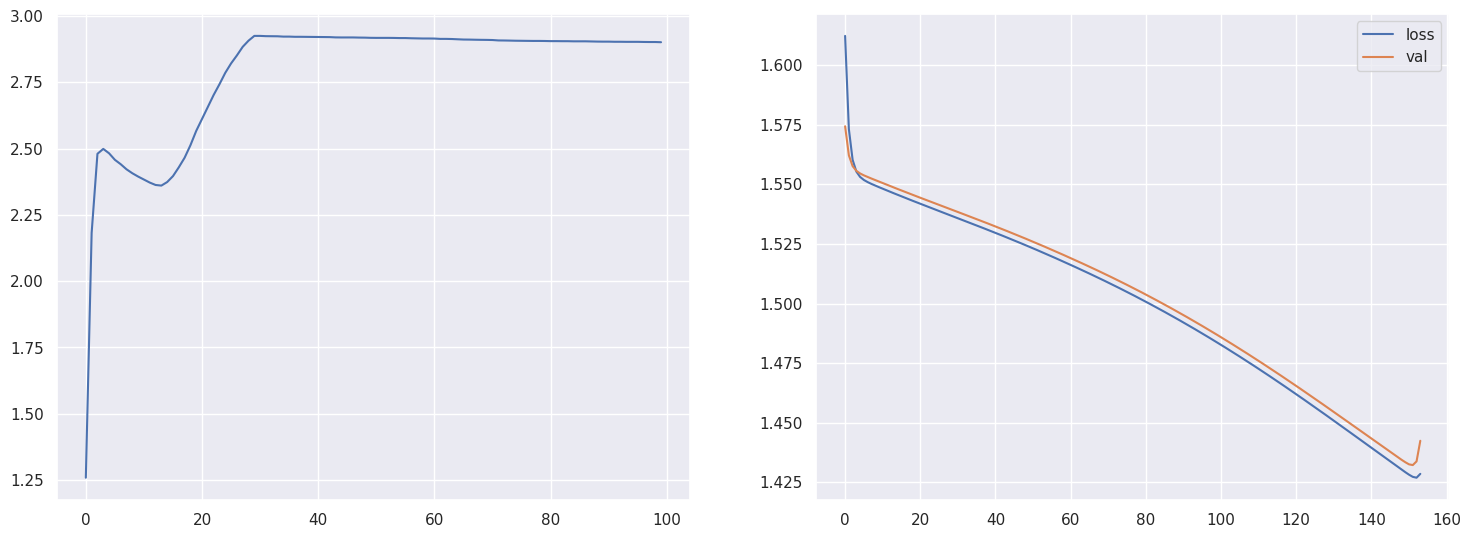

6
7
Final Training Loss: 1.296
Epoch: 225
break converge at epoch 40


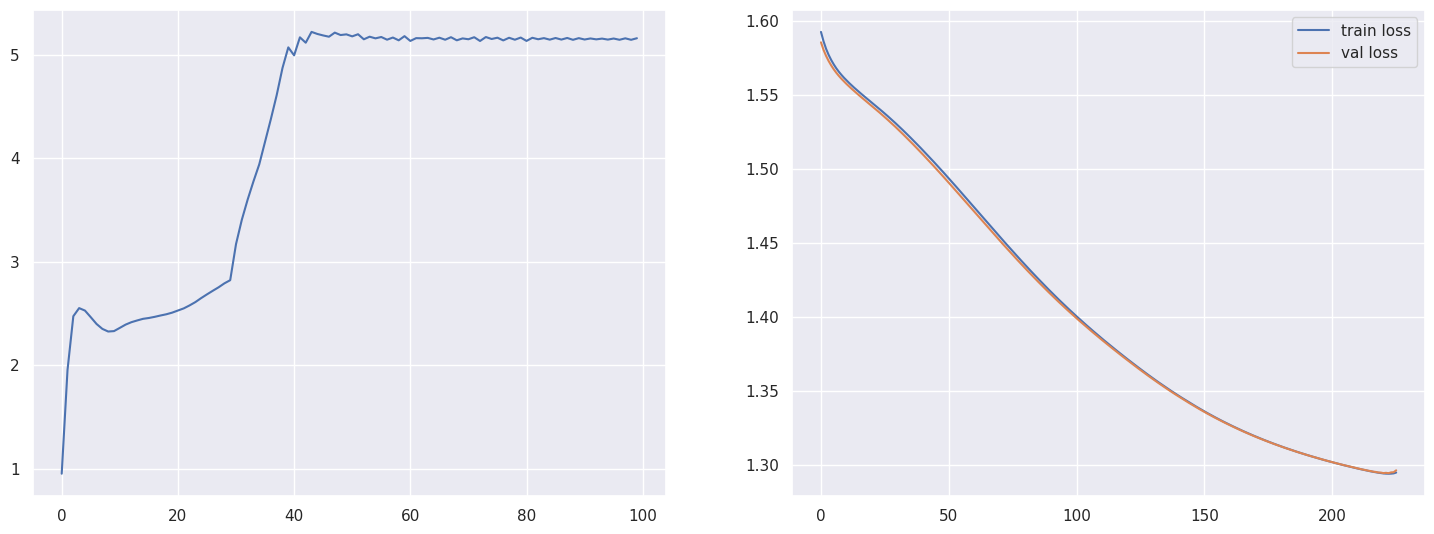

7


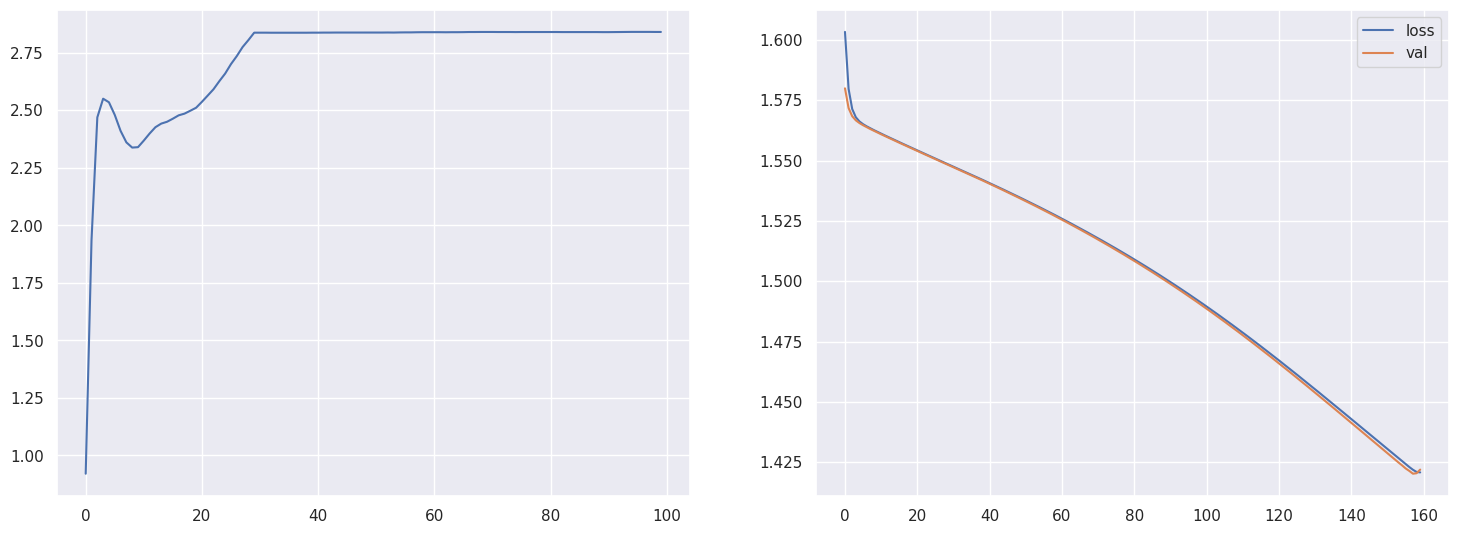

7
8
Final Training Loss: 1.285
Epoch: 299


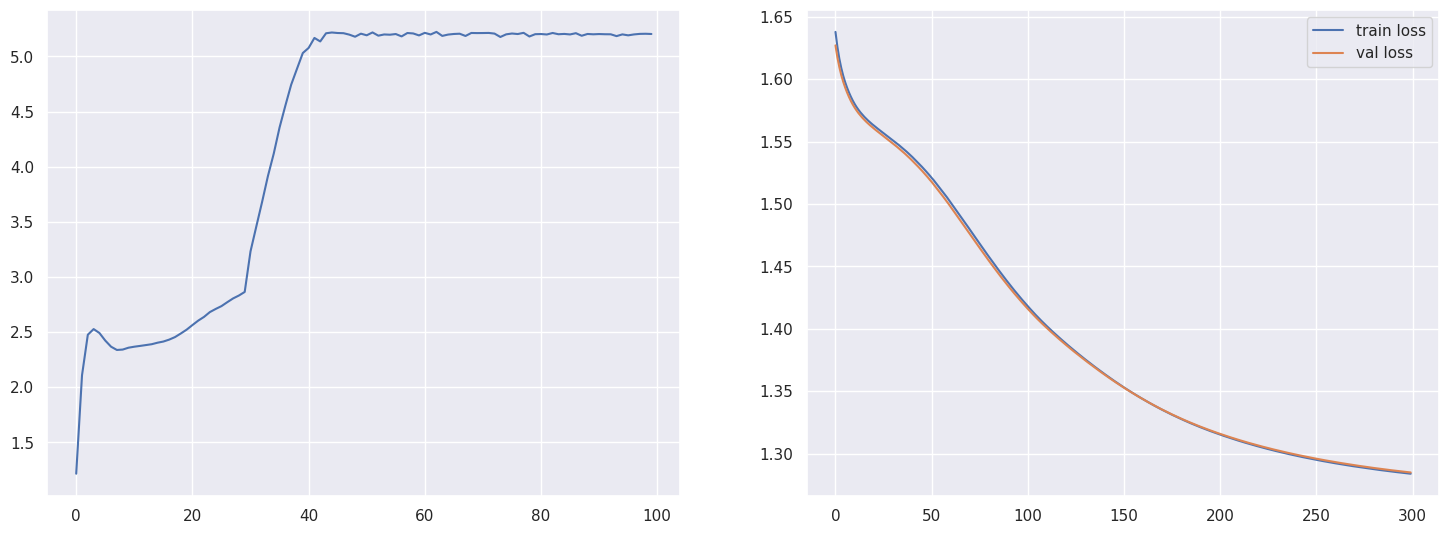

8


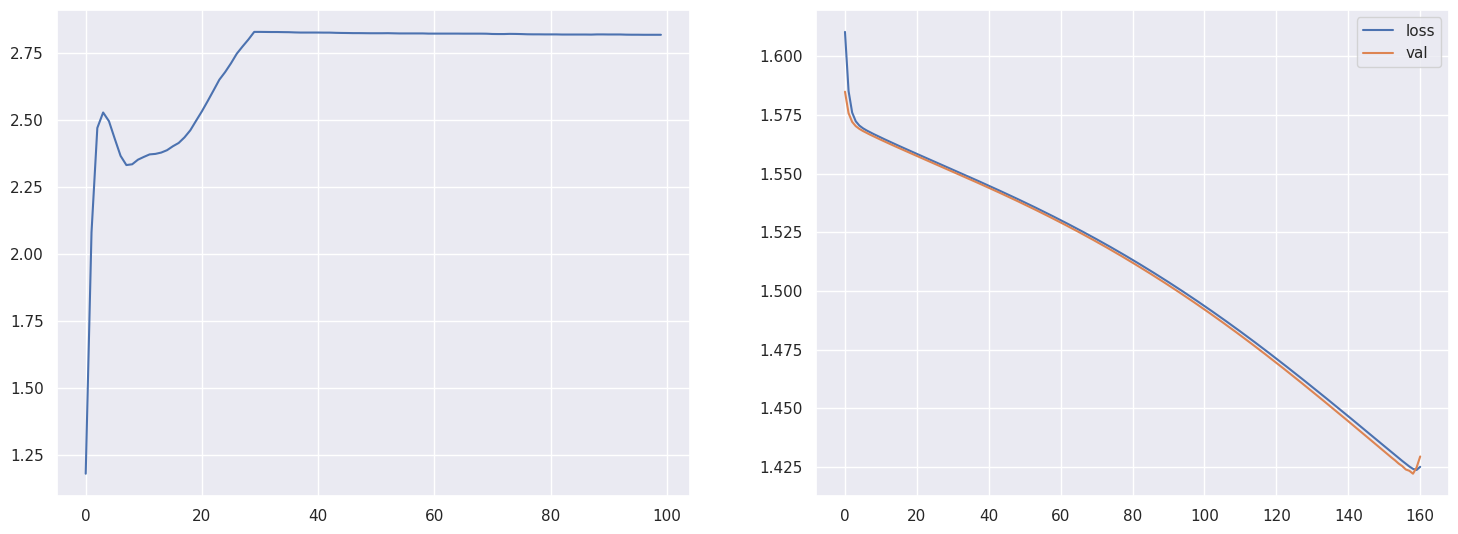

8
9
Final Training Loss: 1.335
Epoch: 186


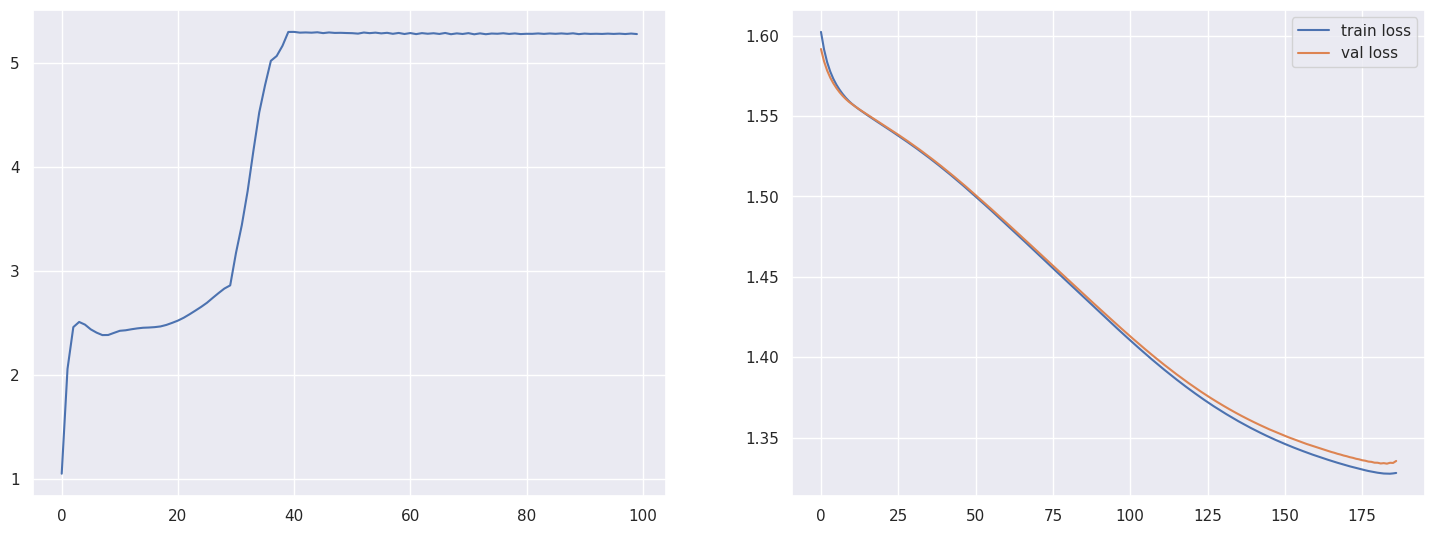

9


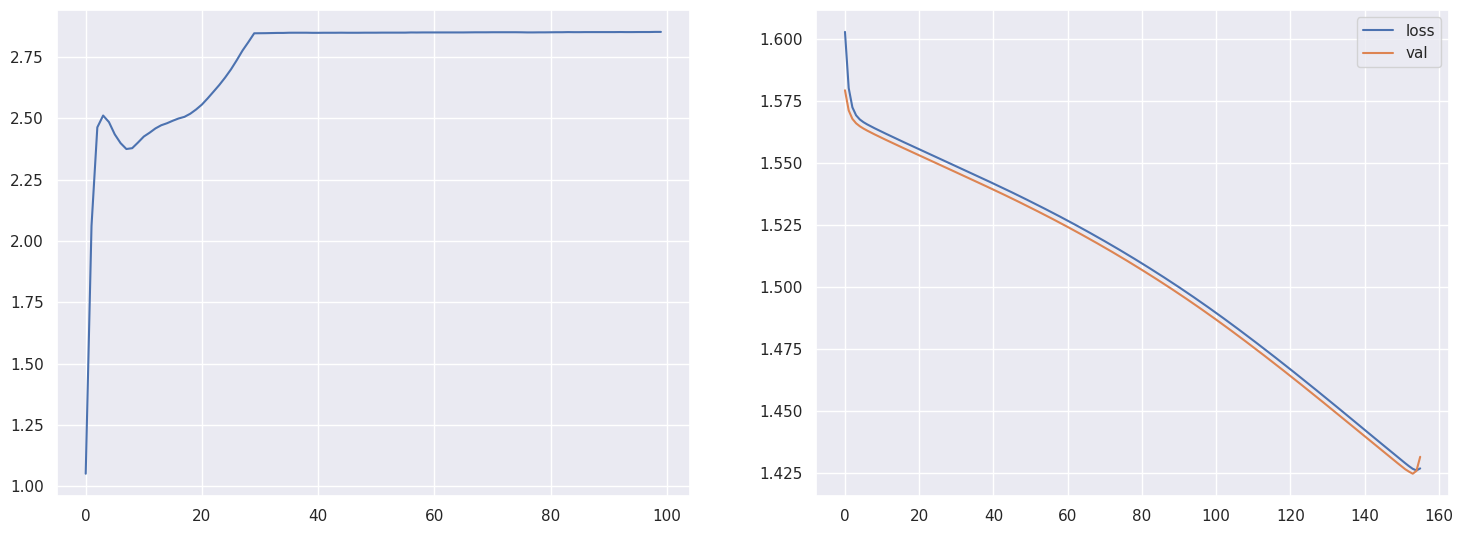

9
0.1
0
Final Training Loss: 1.314
Epoch: 299


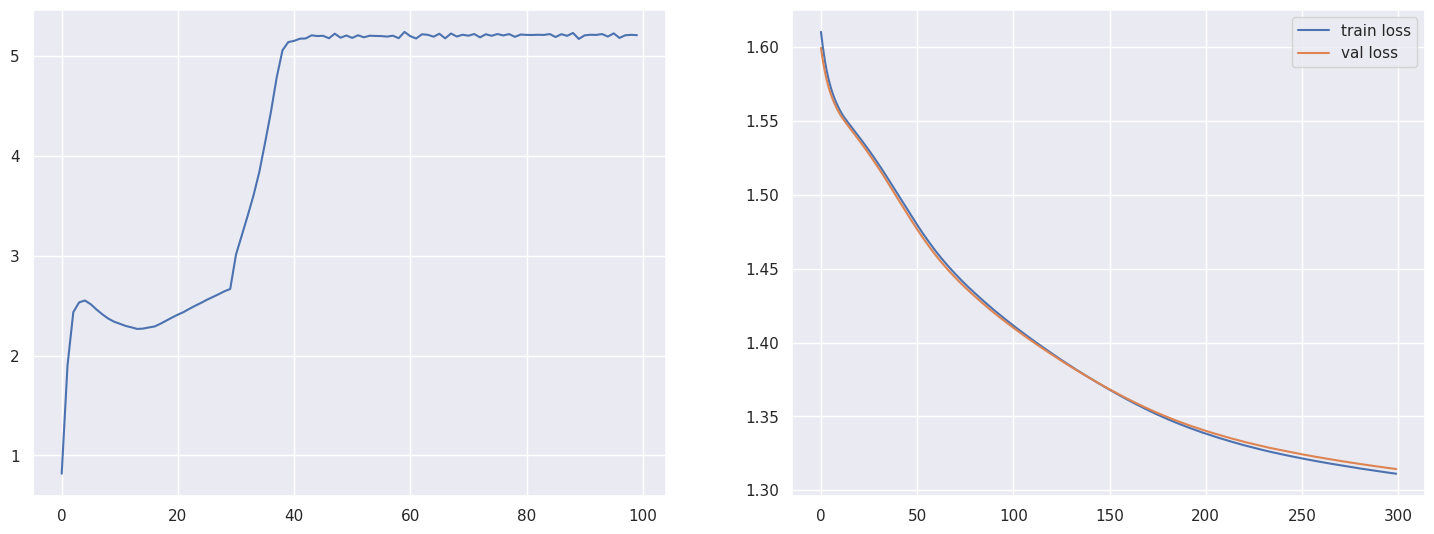

0


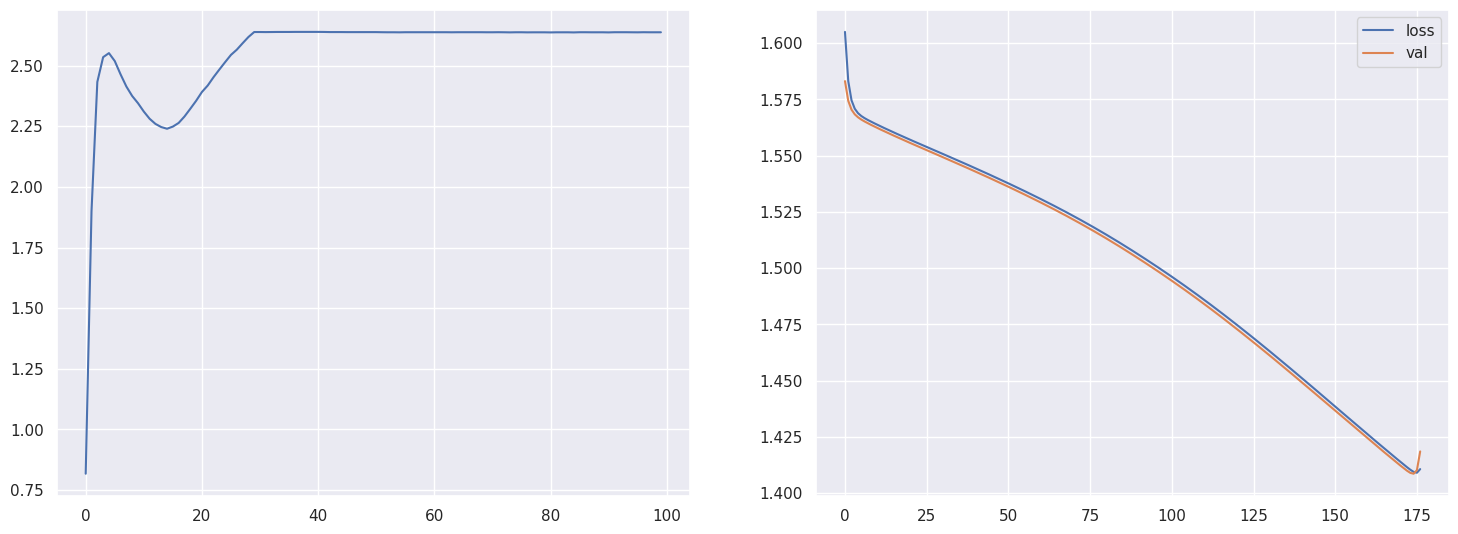

0
1
Final Training Loss: 1.293
Epoch: 299


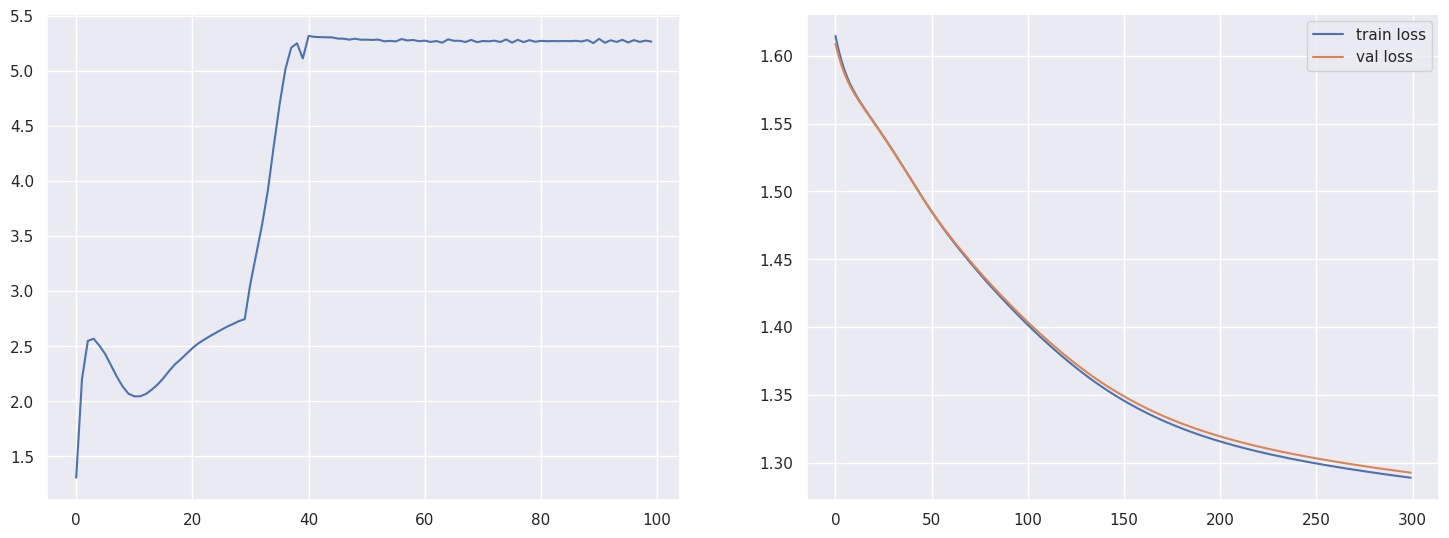

1


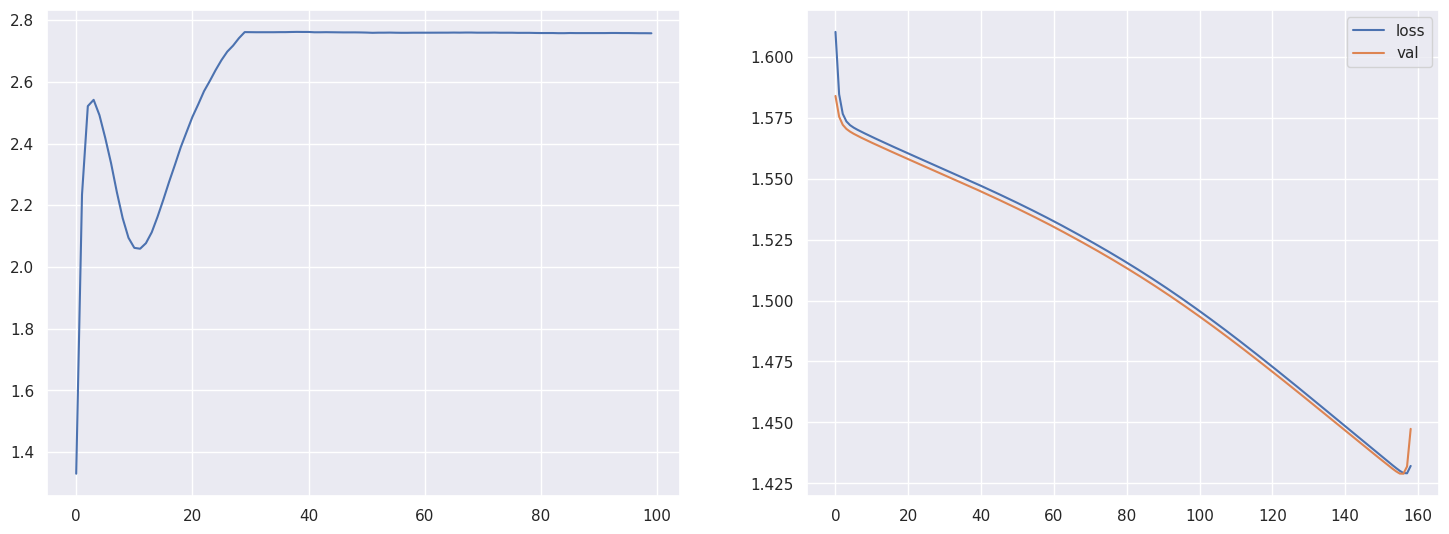

1
2
Final Training Loss: 1.292
Epoch: 299


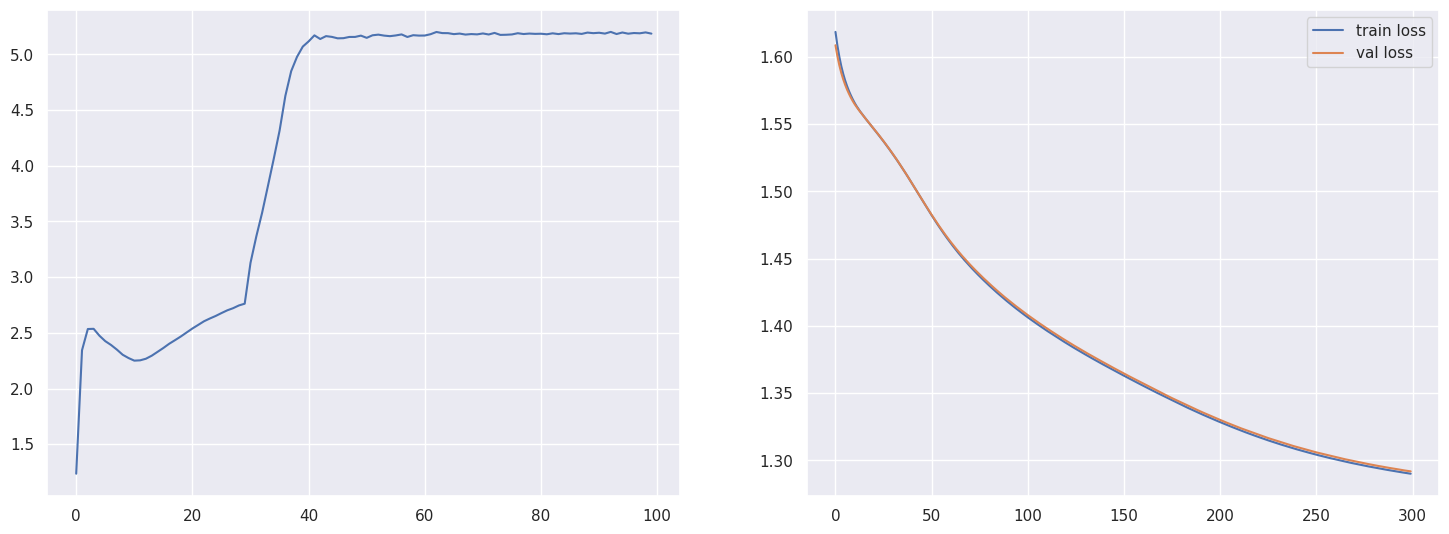

2


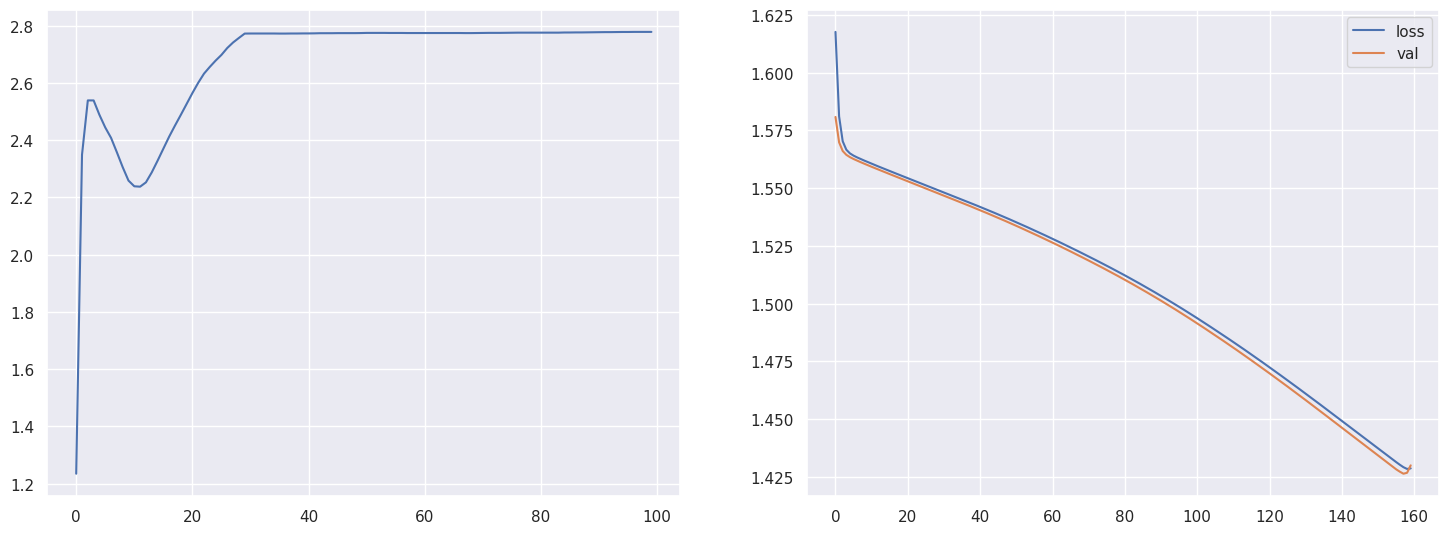

2
3
Final Training Loss: 1.283
Epoch: 299


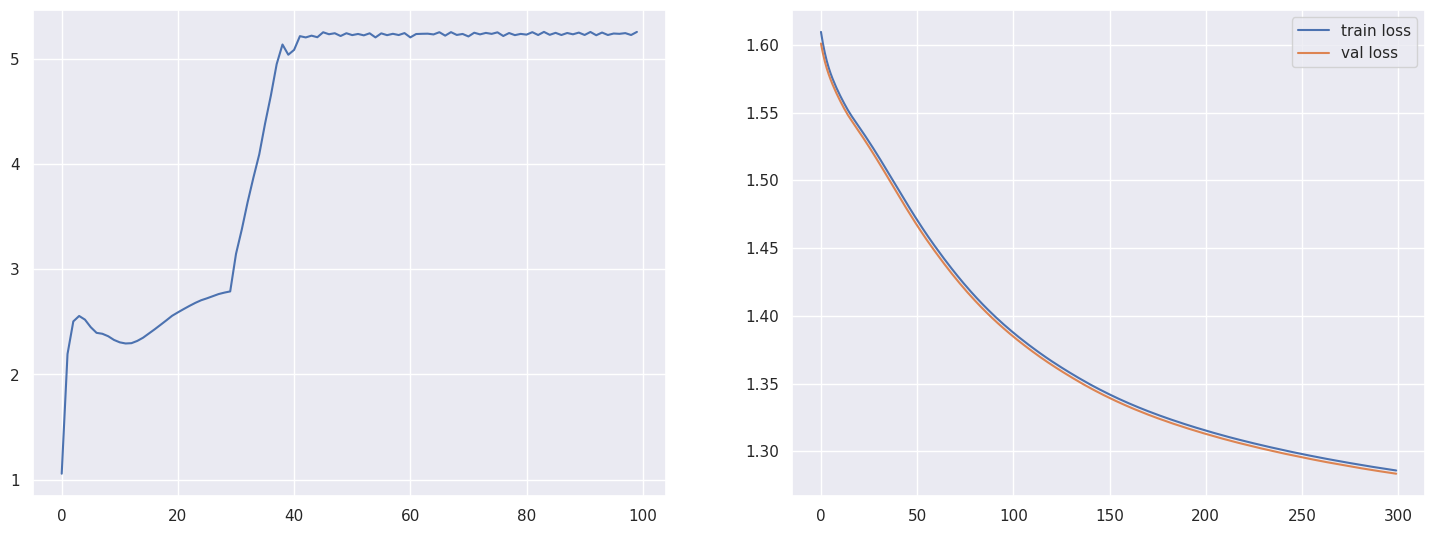

3


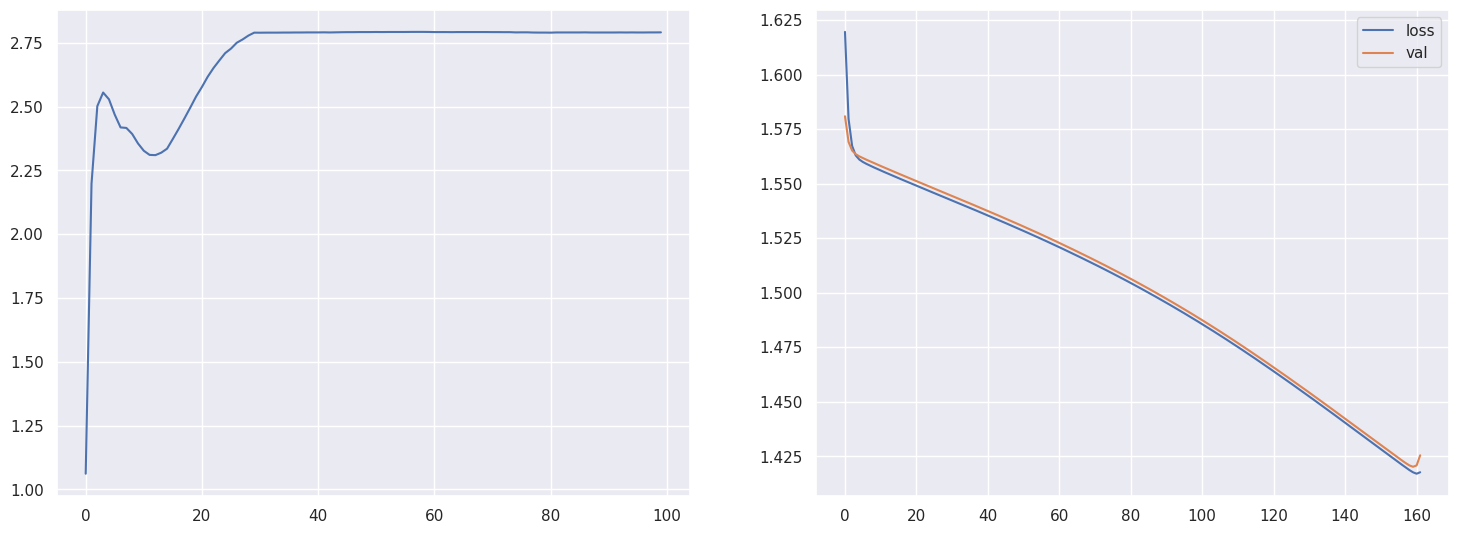

3
4
Final Training Loss: 1.300
Epoch: 230


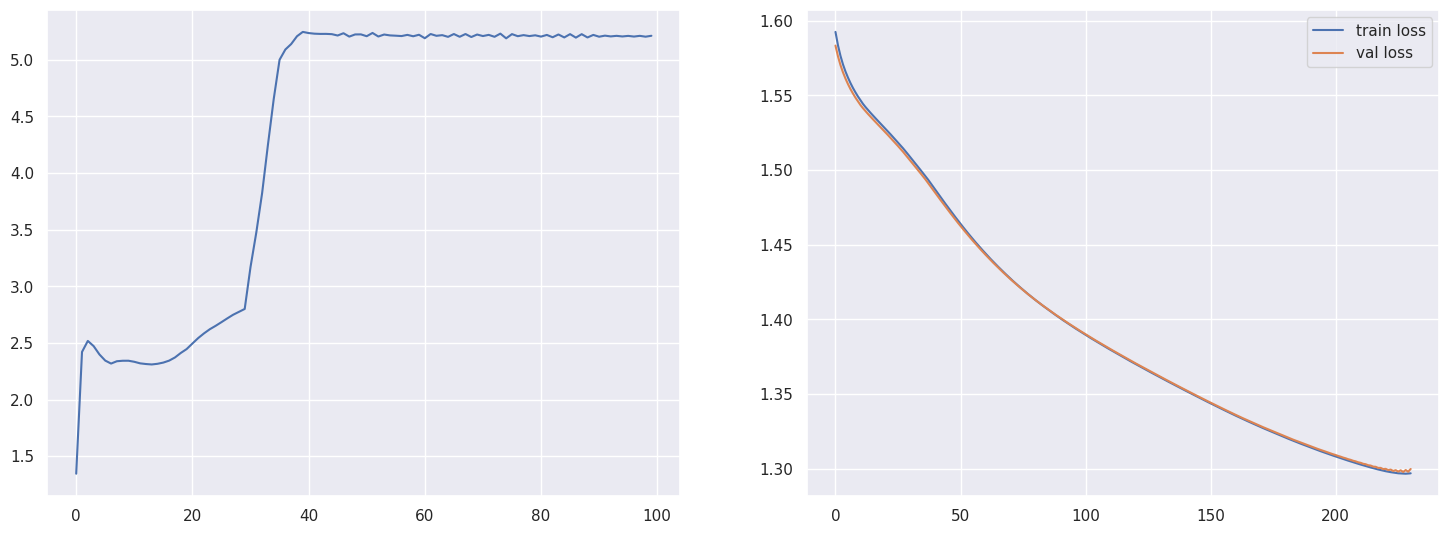

4


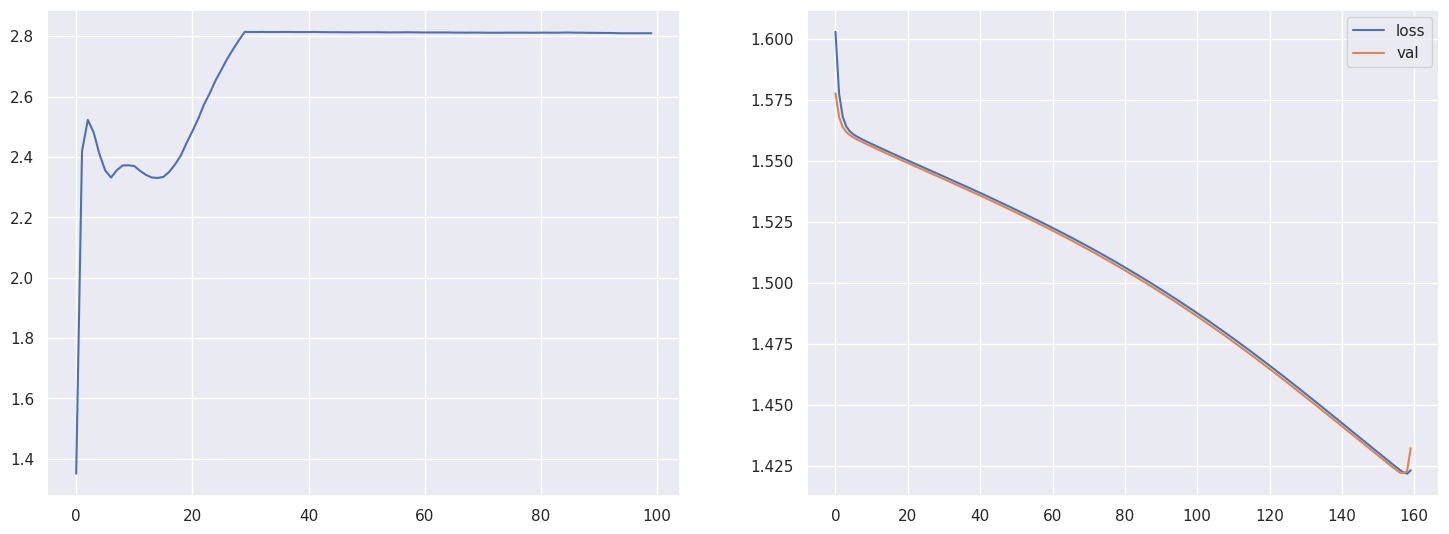

4
5
Final Training Loss: 1.312
Epoch: 299


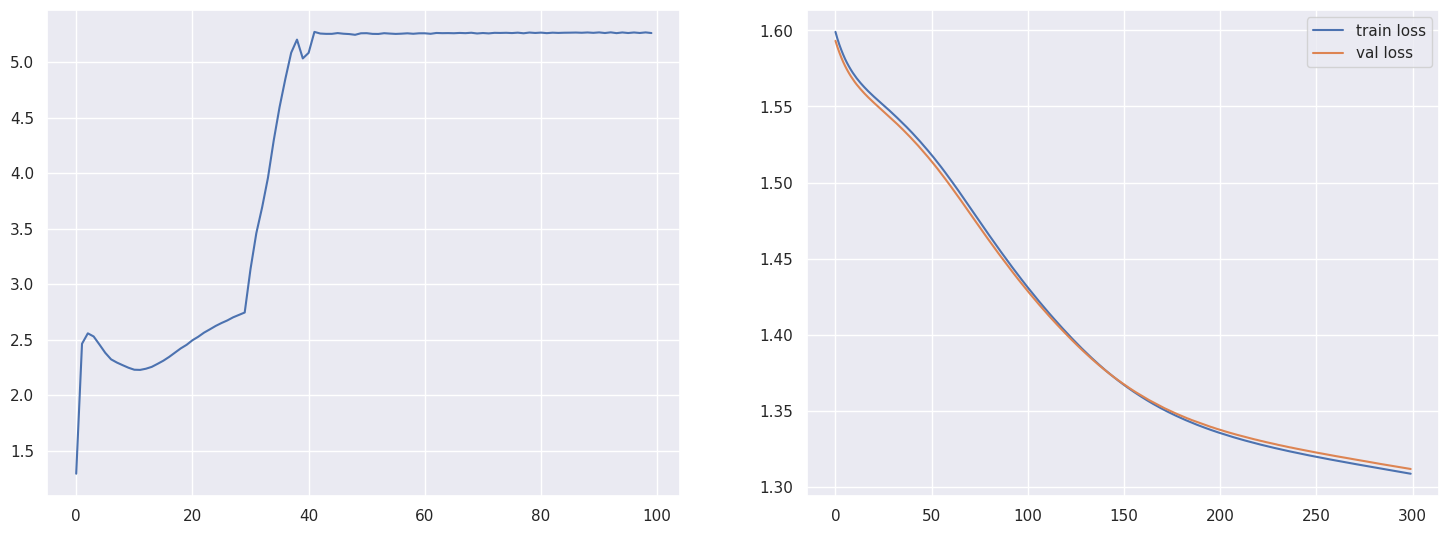

5


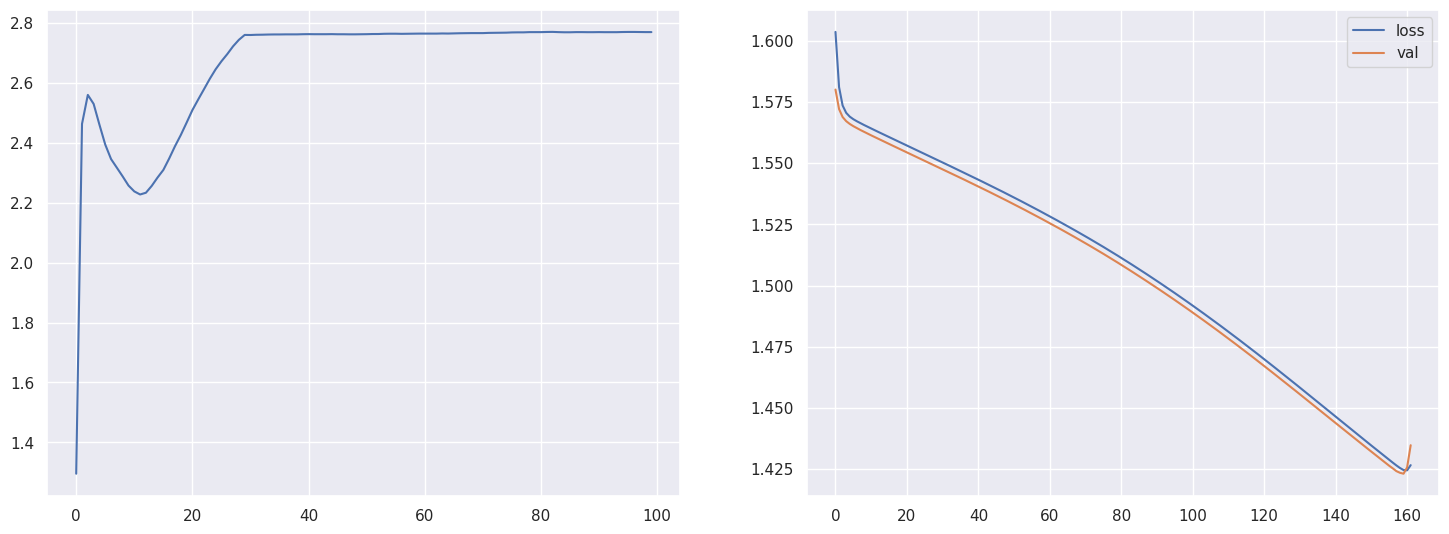

5
6
Final Training Loss: 1.299
Epoch: 299


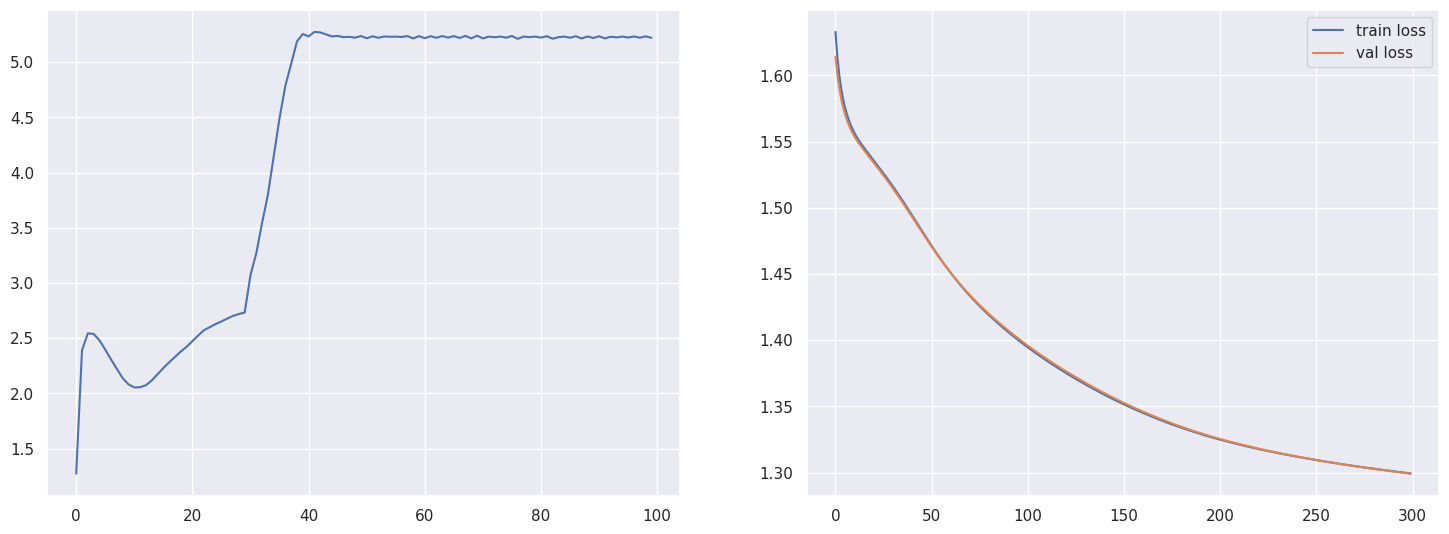

6


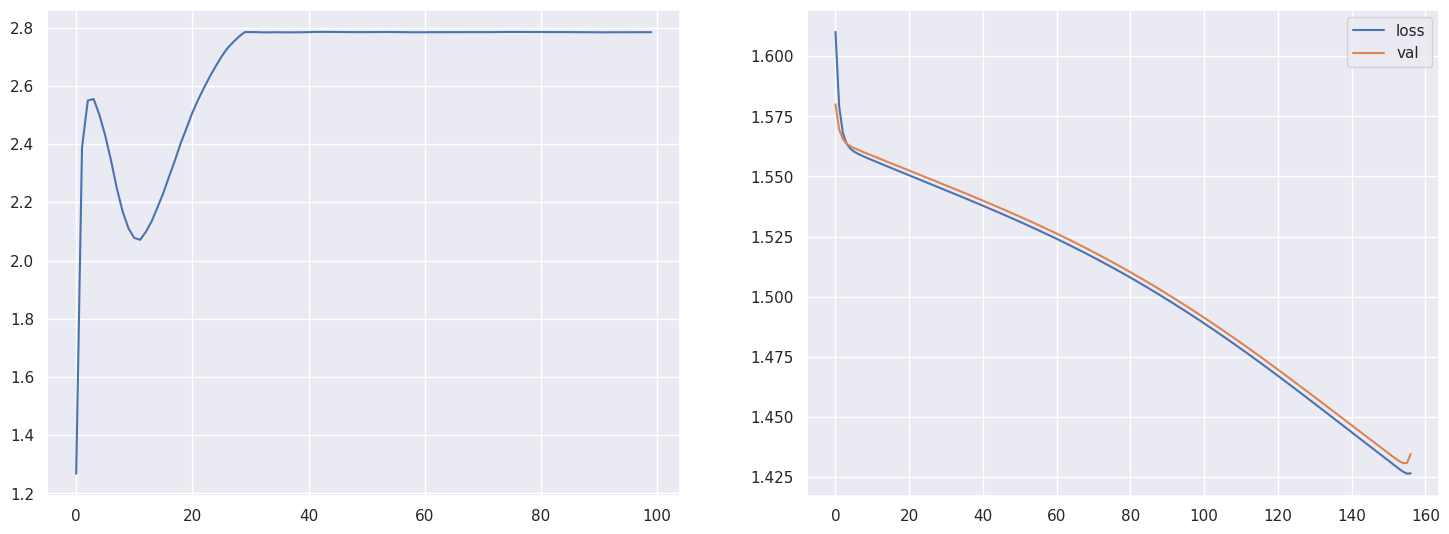

6
7
Final Training Loss: 1.299
Epoch: 230


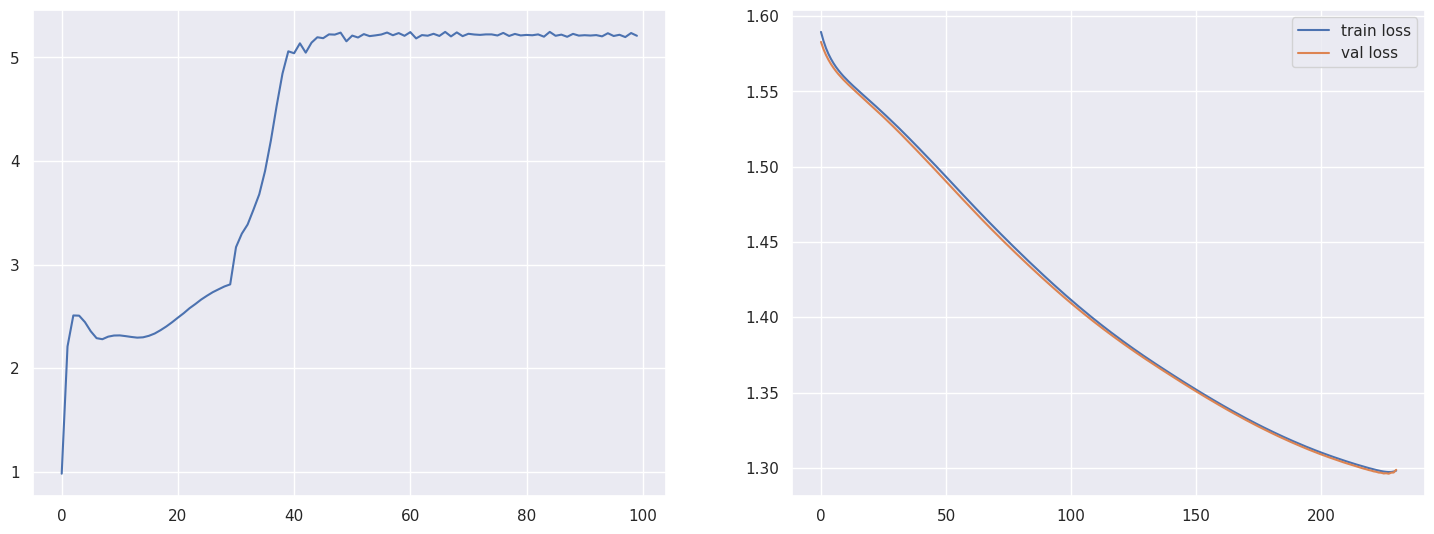

7


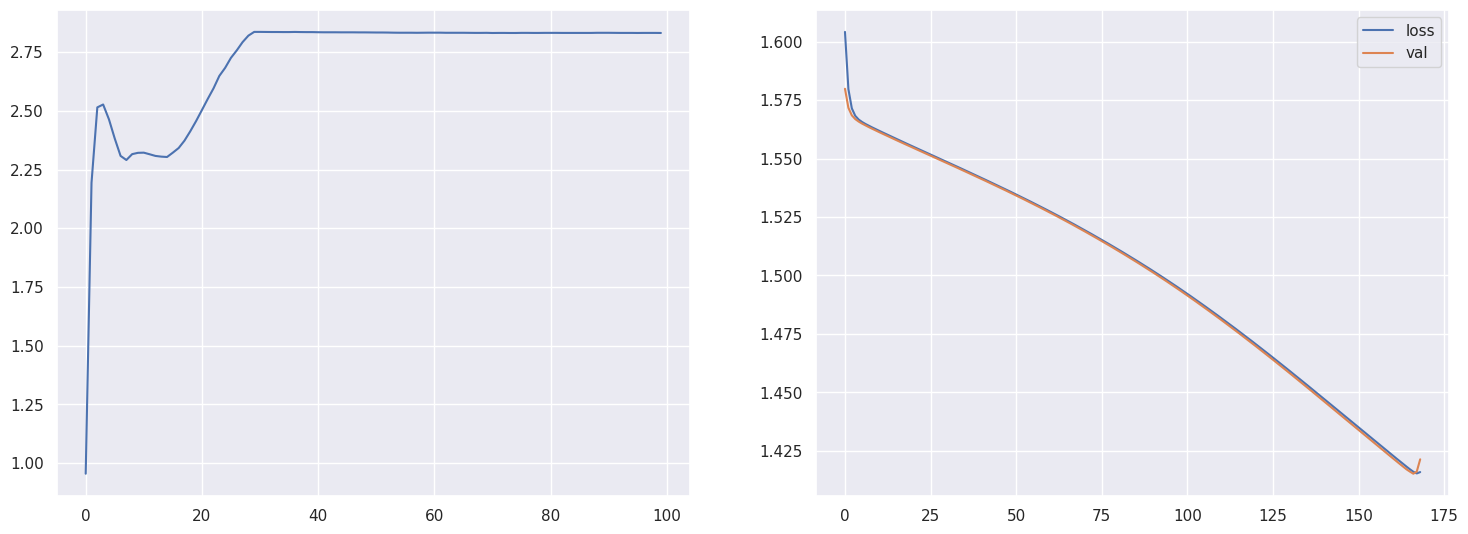

7
8
Final Training Loss: 1.313
Epoch: 299


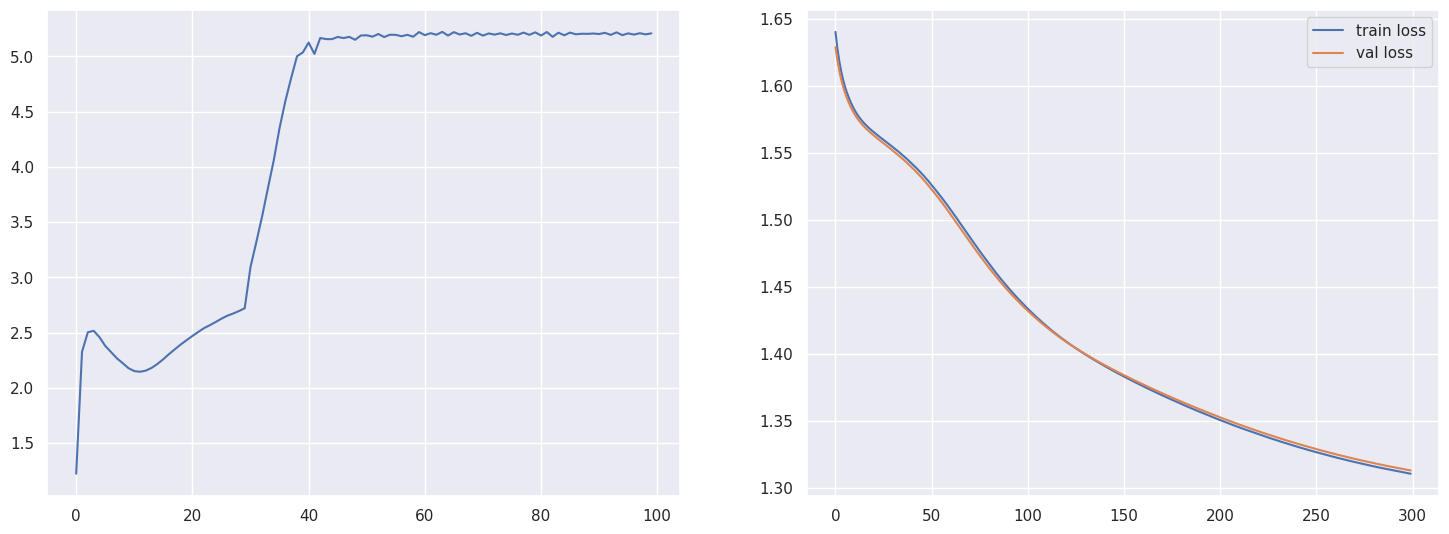

8


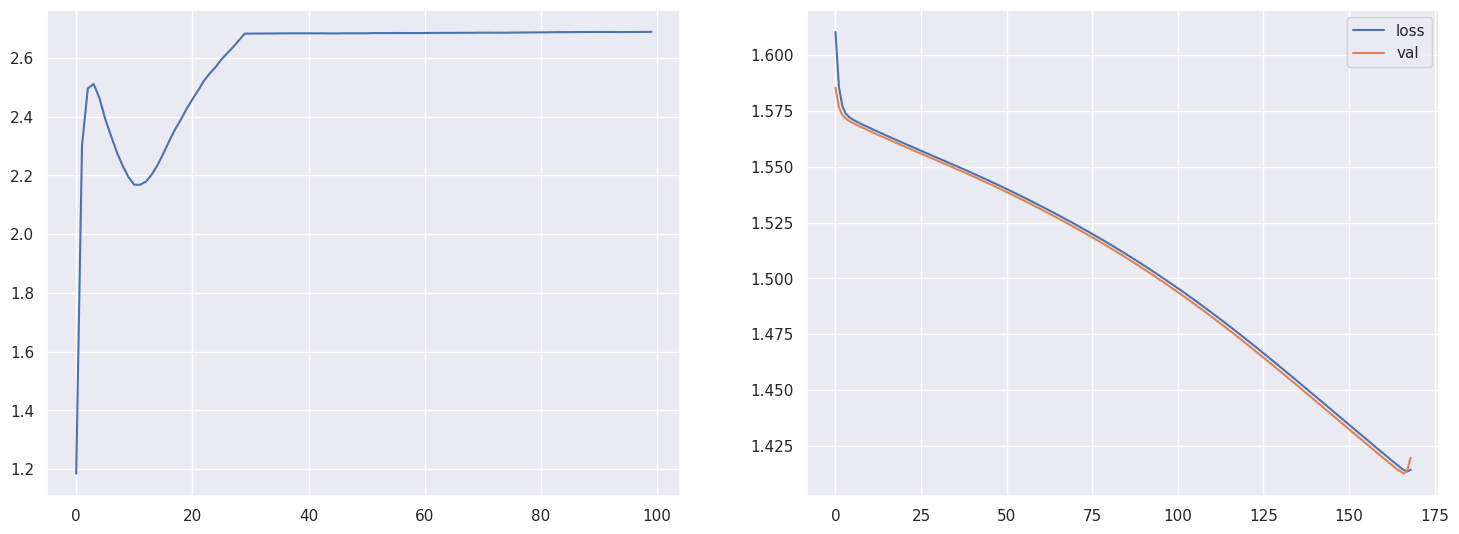

8
9
Final Training Loss: 1.346
Epoch: 195
break converge at epoch 37


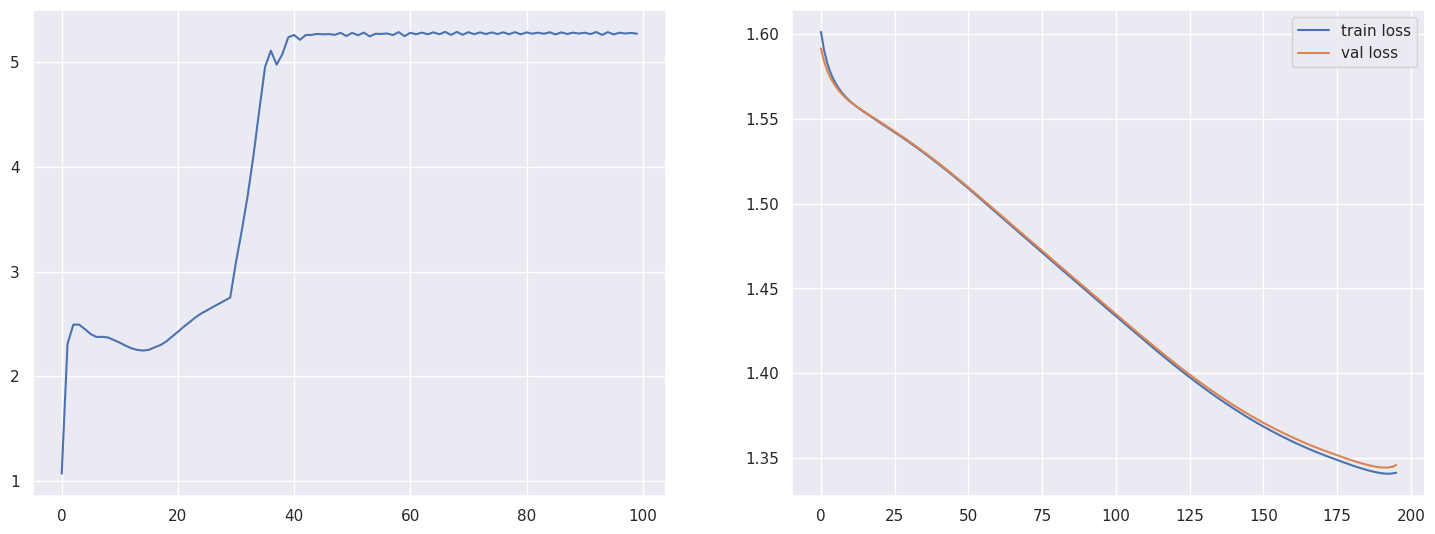

9


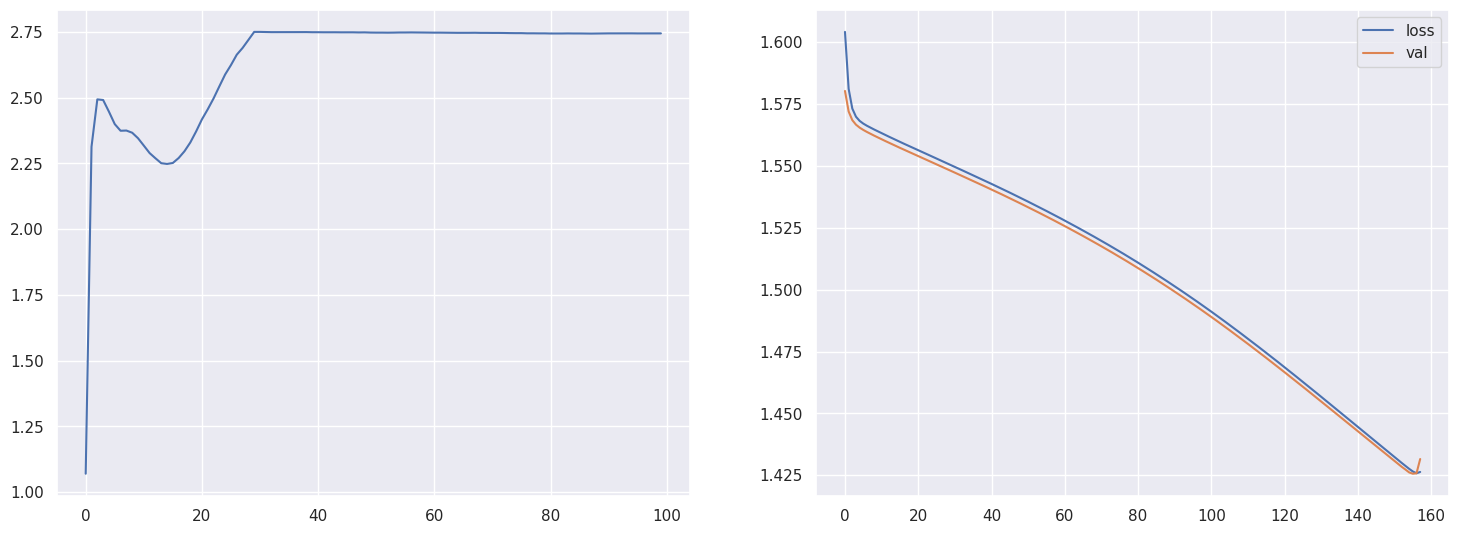

9
0.05
0
Final Training Loss: 1.341
Epoch: 299


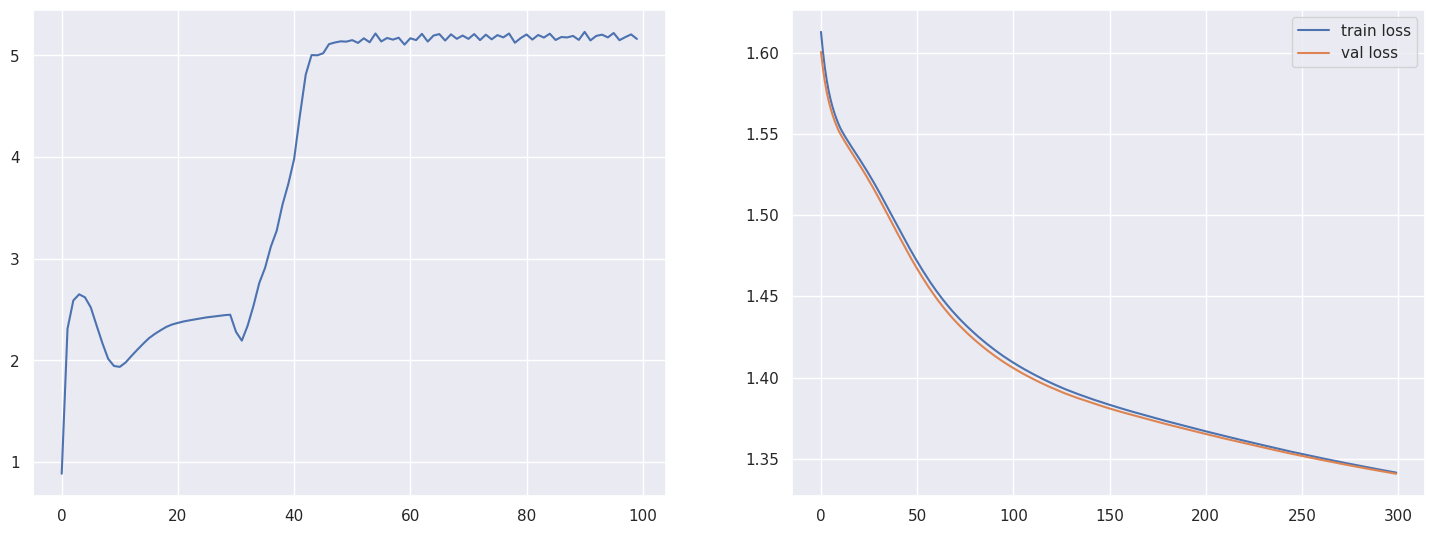

0


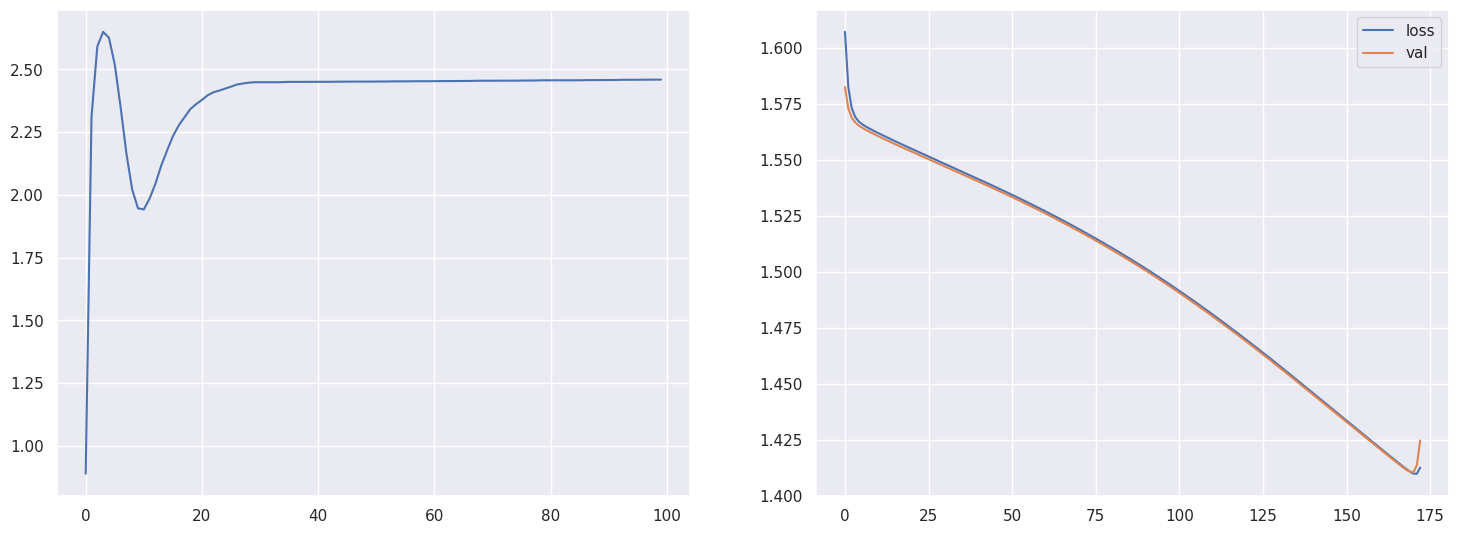

0
1
Final Training Loss: 1.328
Epoch: 299
break converge at epoch 39


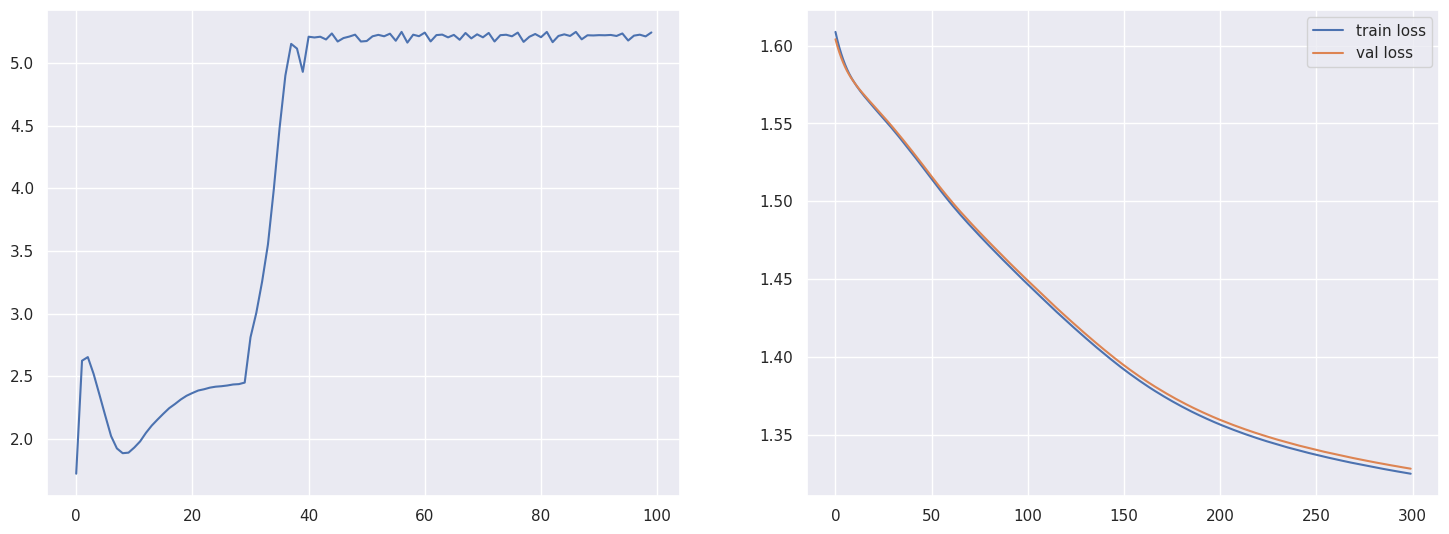

1


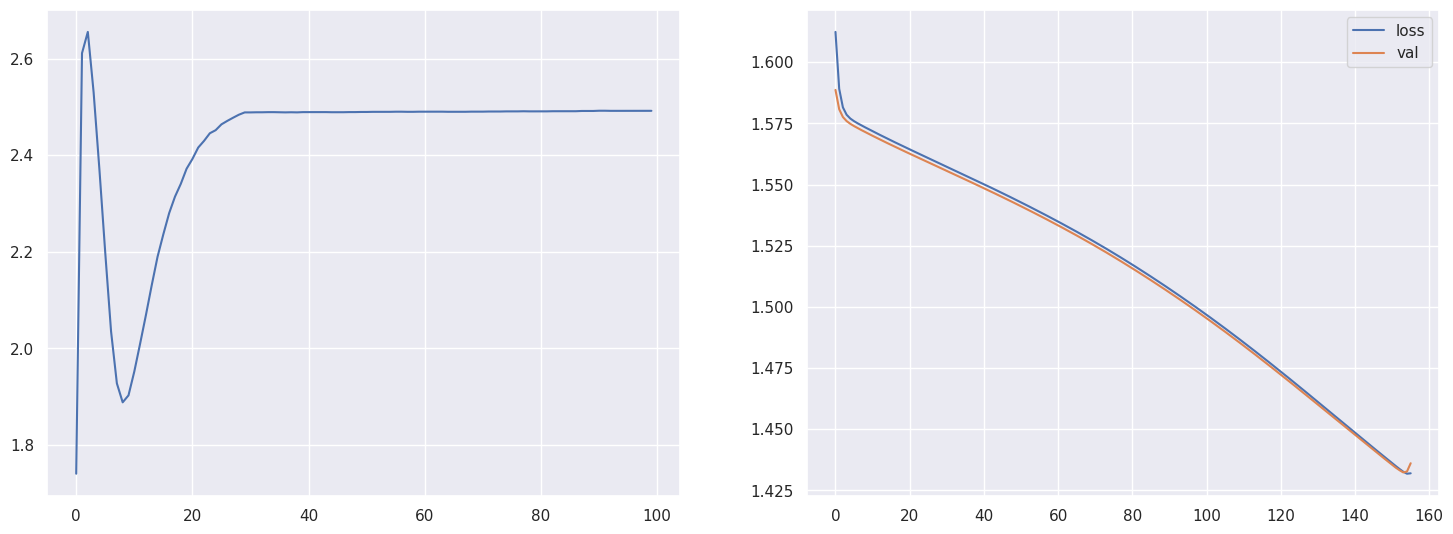

1
2
Final Training Loss: 1.342
Epoch: 299


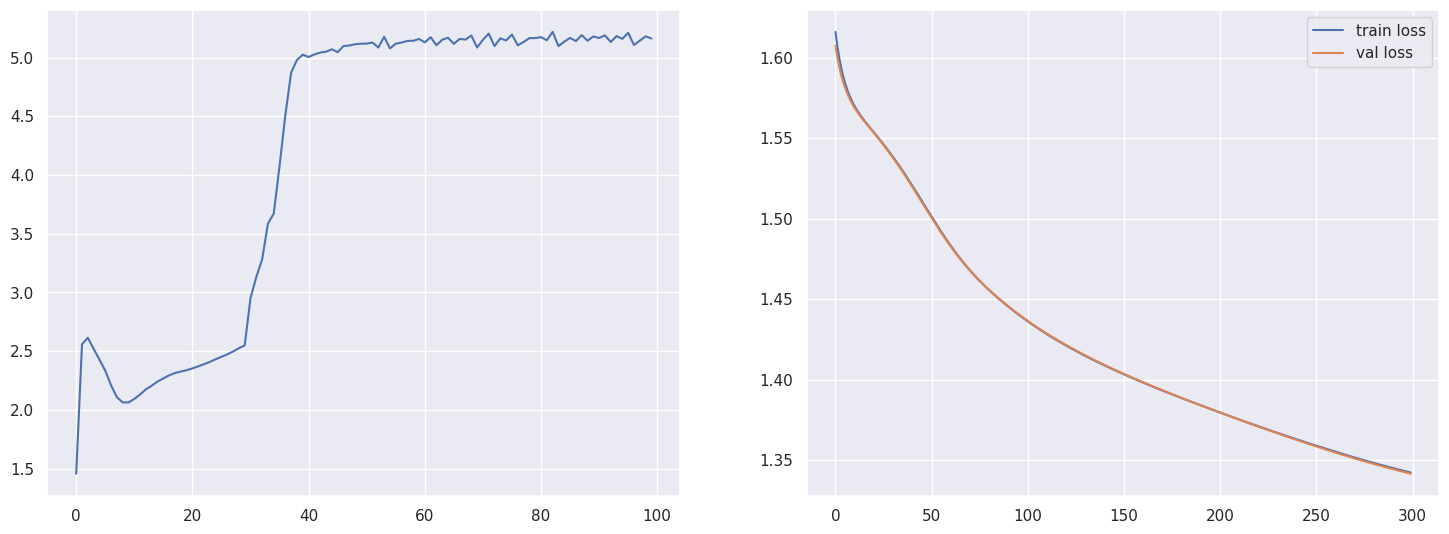

2


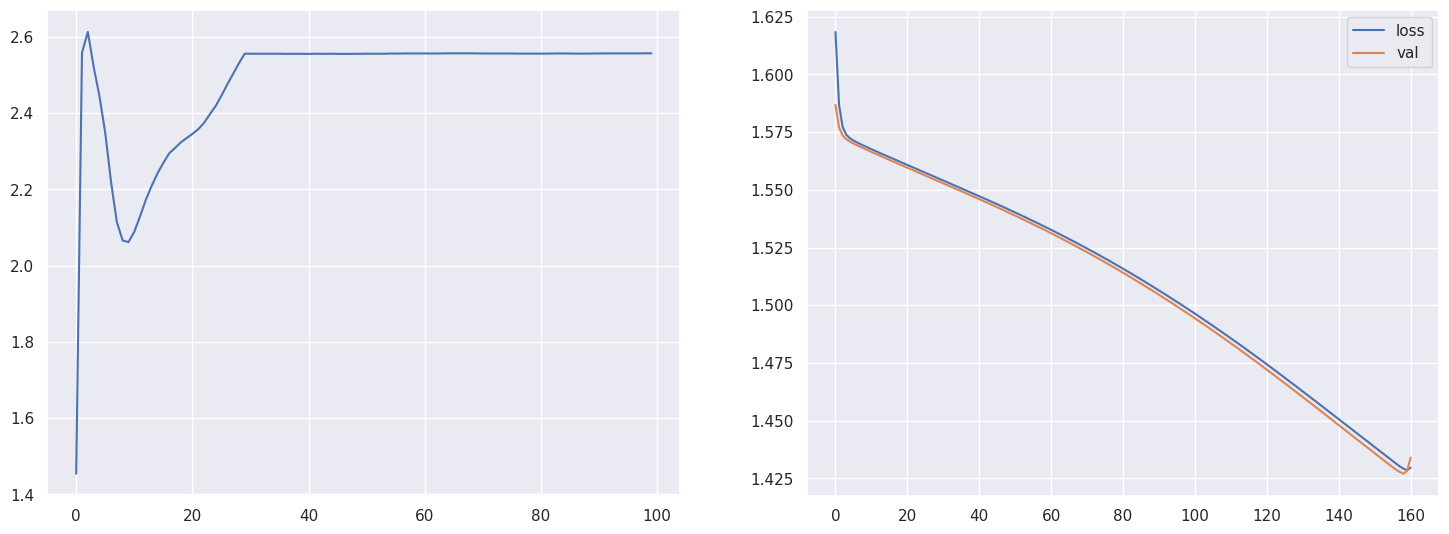

2
3
Final Training Loss: 1.314
Epoch: 299


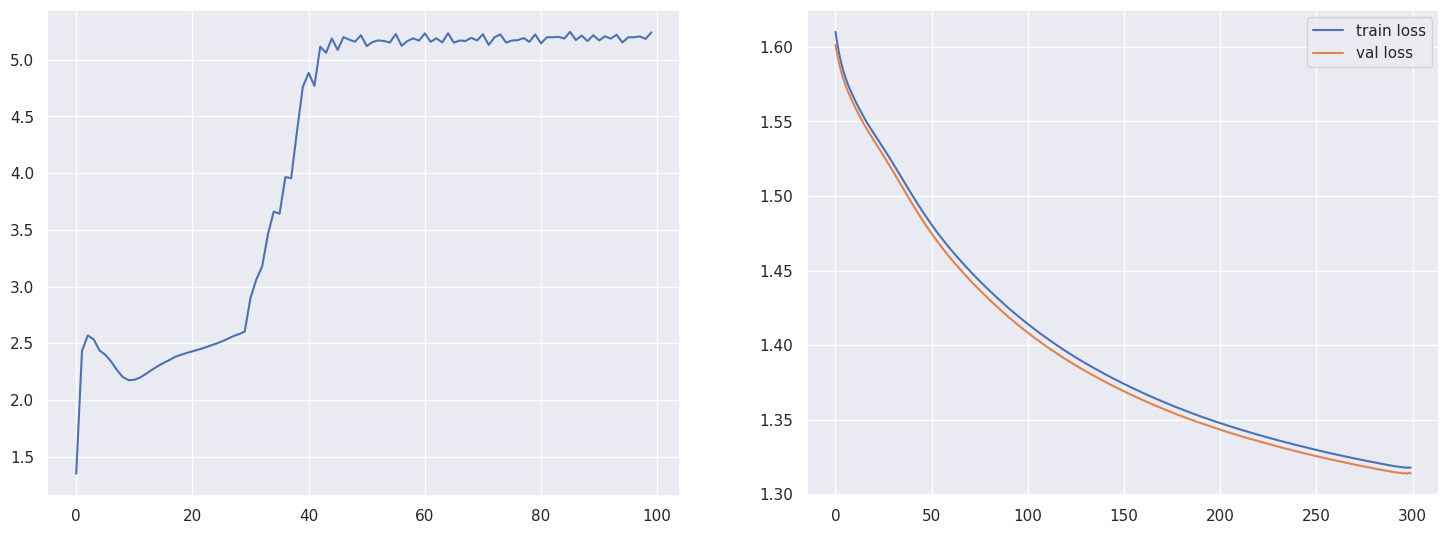

3


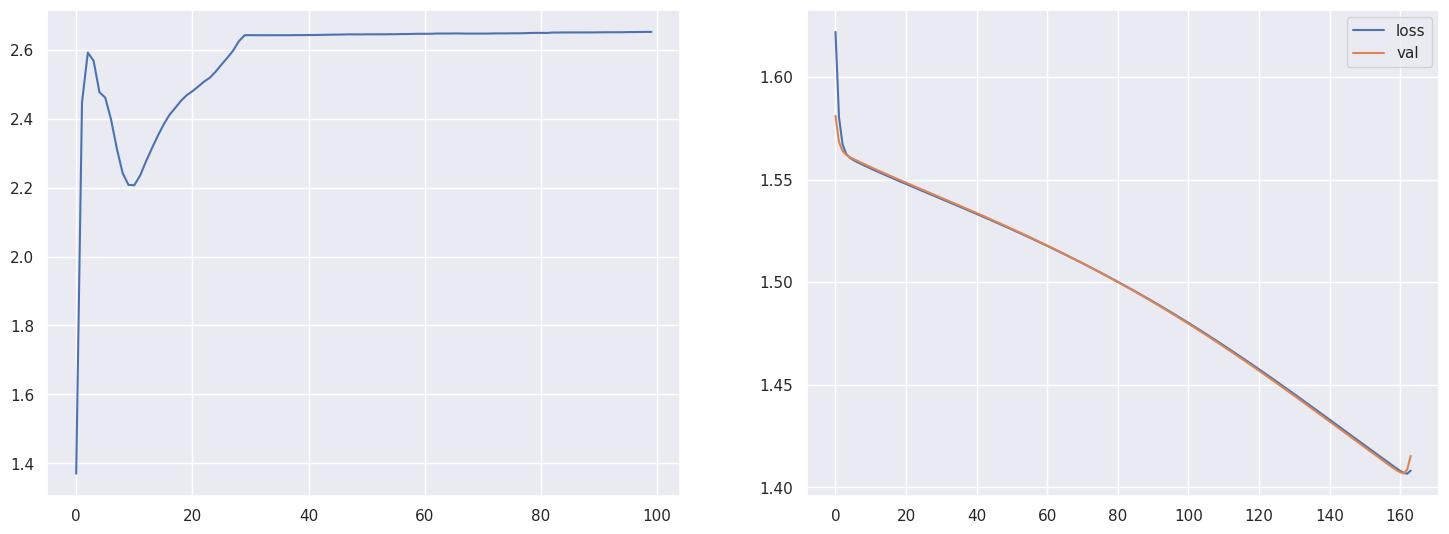

3
4
Final Training Loss: 1.321
Epoch: 249
break converge at epoch 37


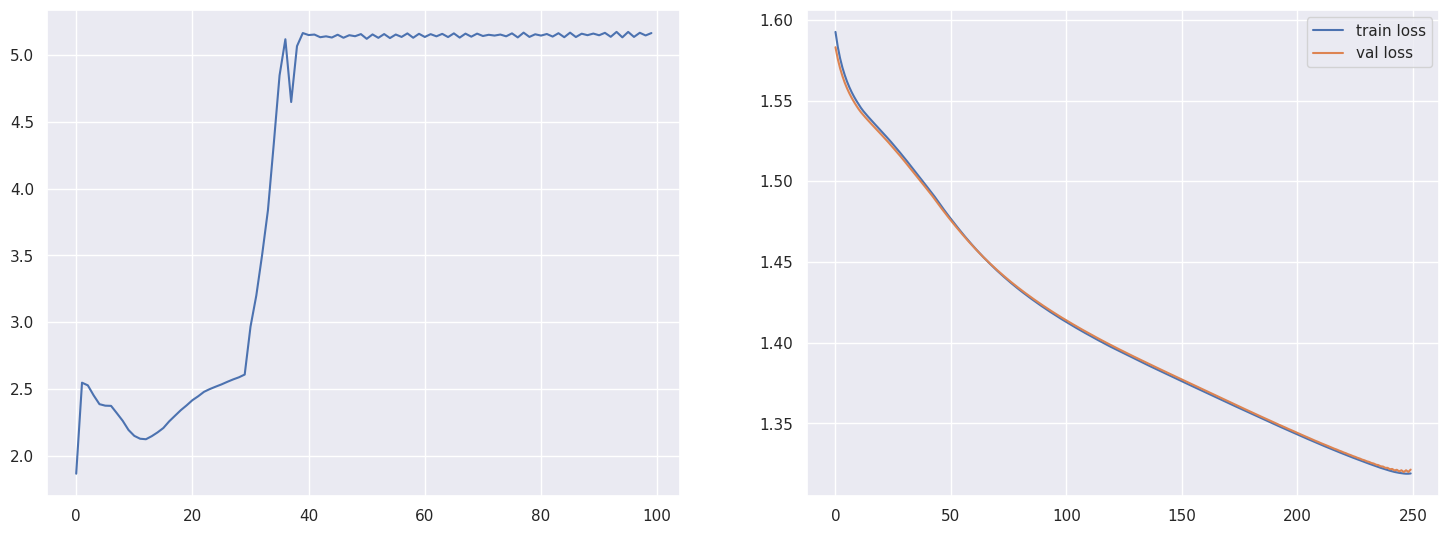

4


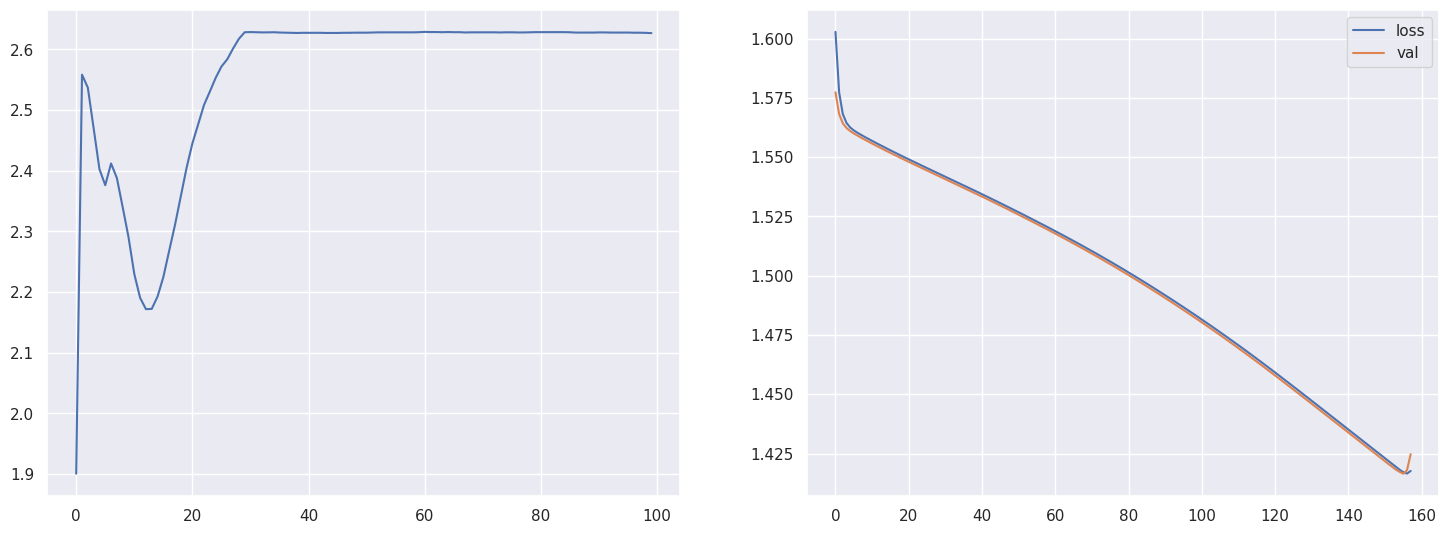

4
5
Final Training Loss: 1.321
Epoch: 299


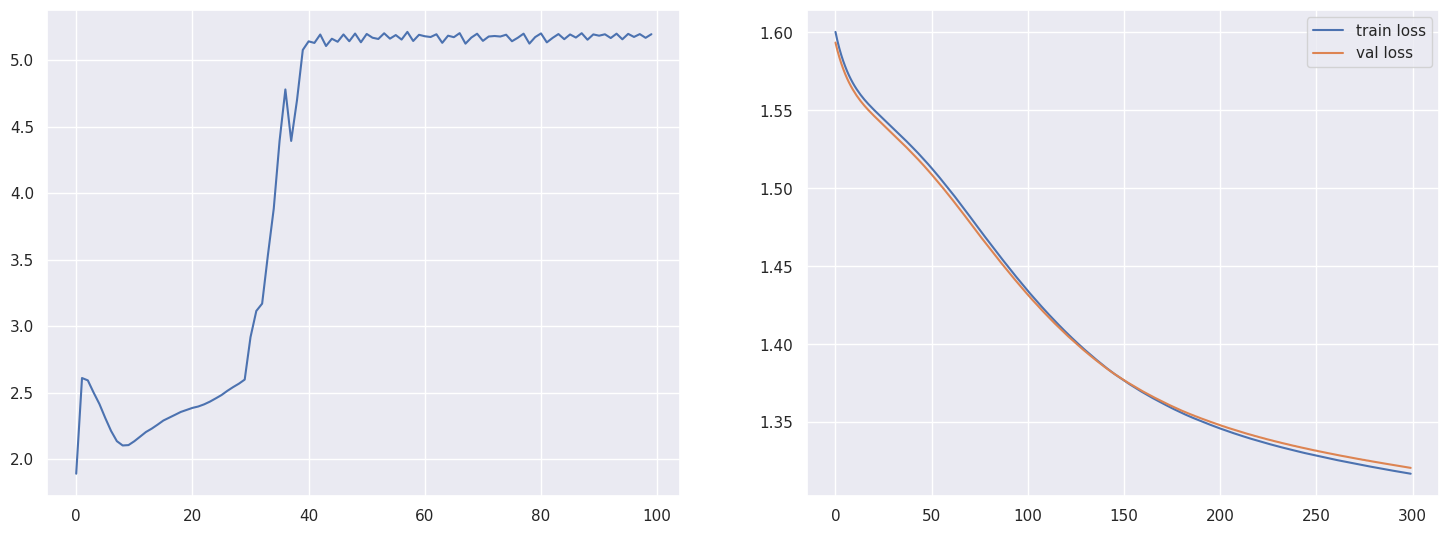

5


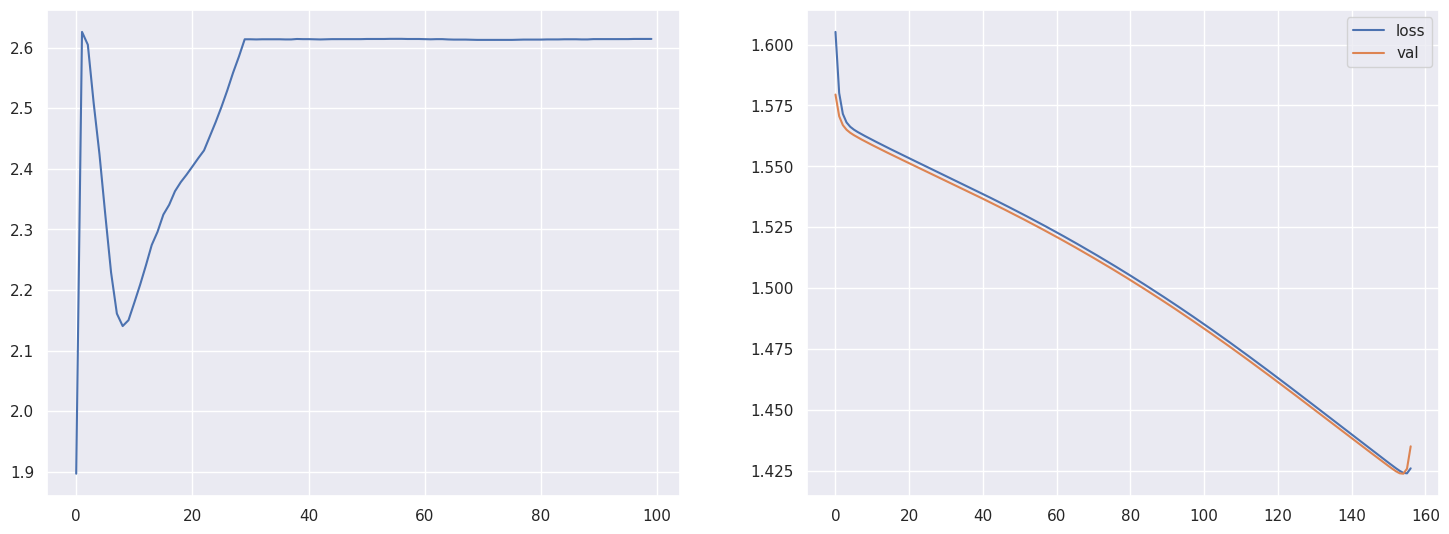

5
6
Final Training Loss: 1.355
Epoch: 248


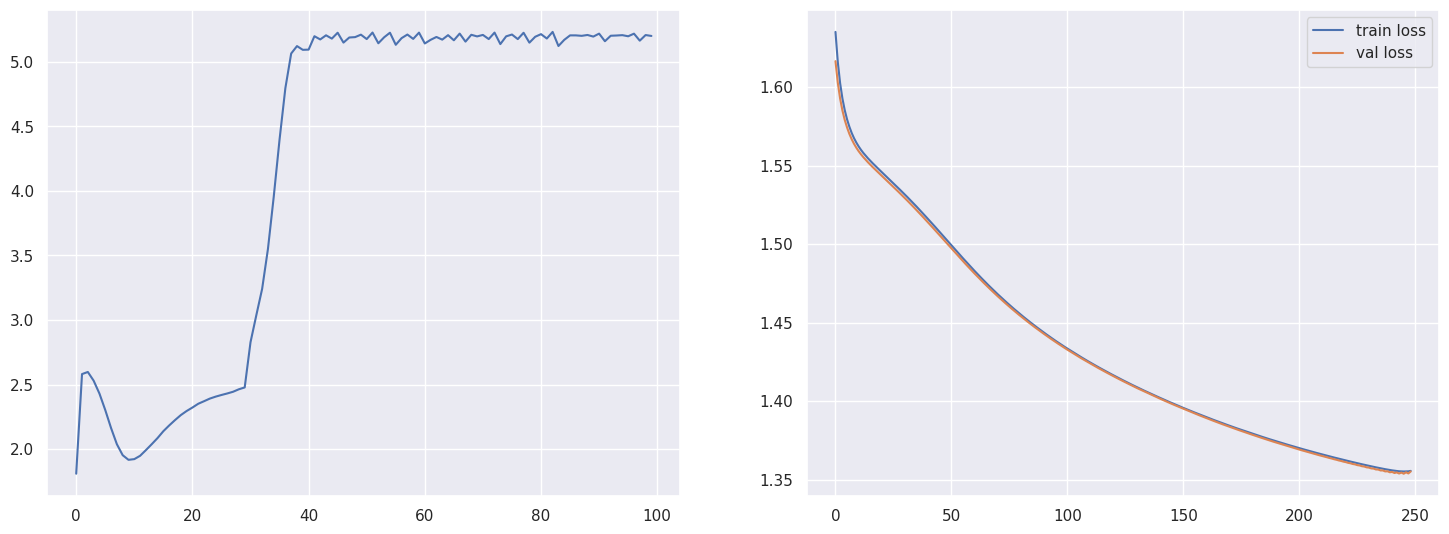

6


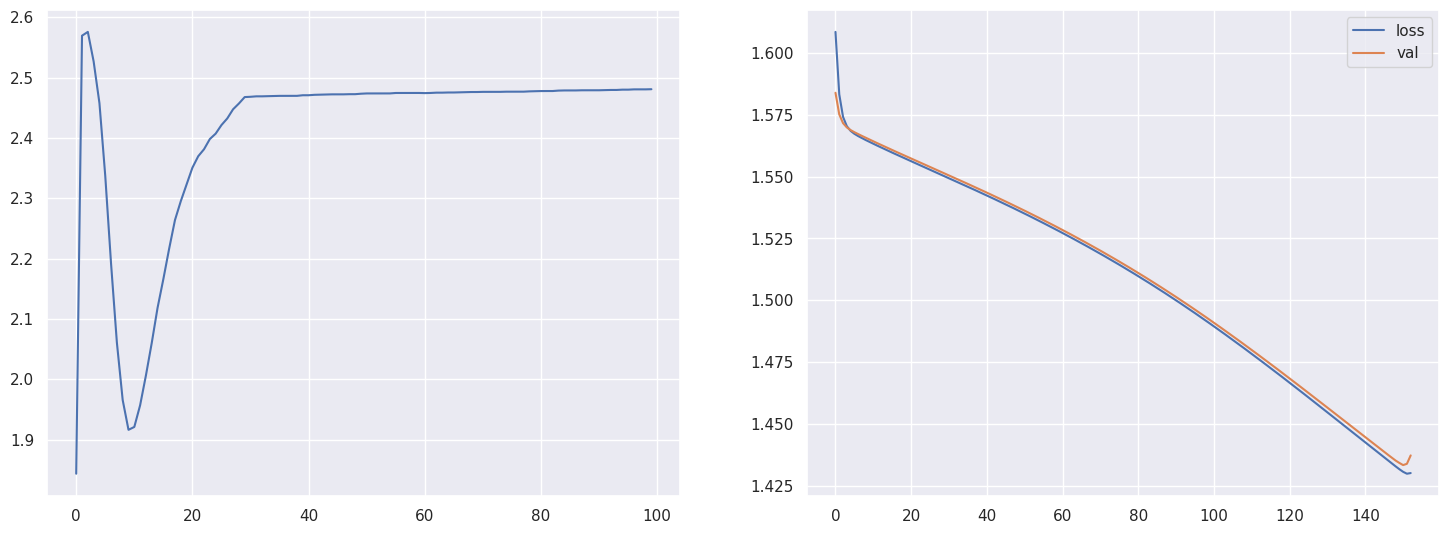

6
7
Final Training Loss: 1.336
Epoch: 252


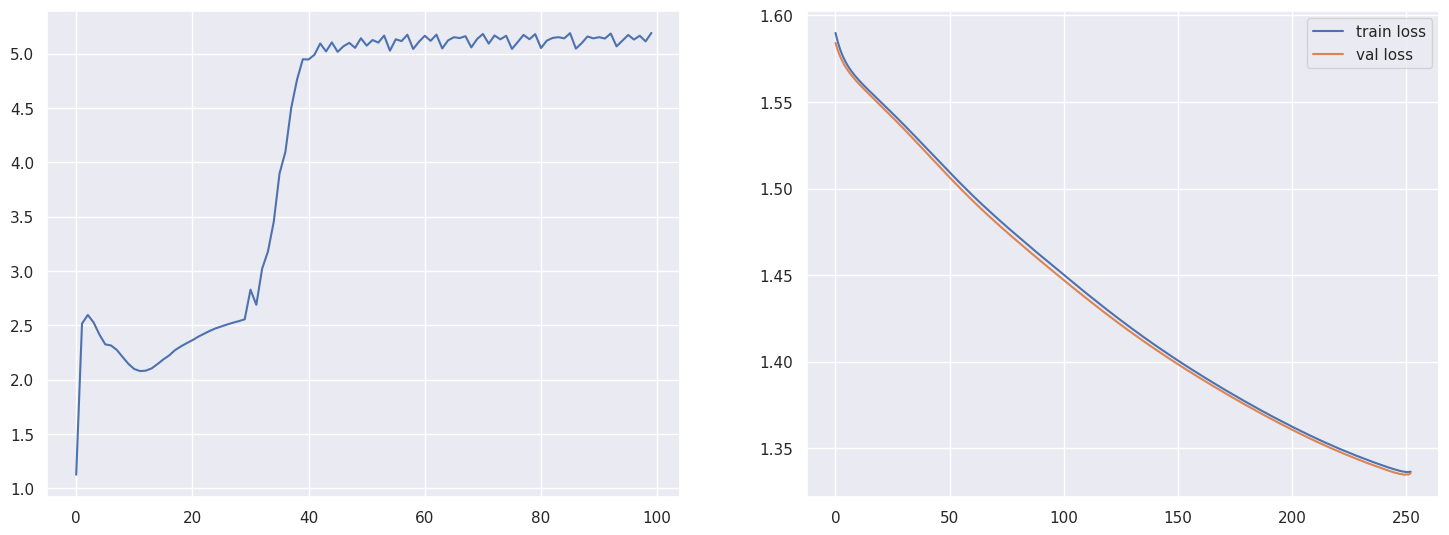

7


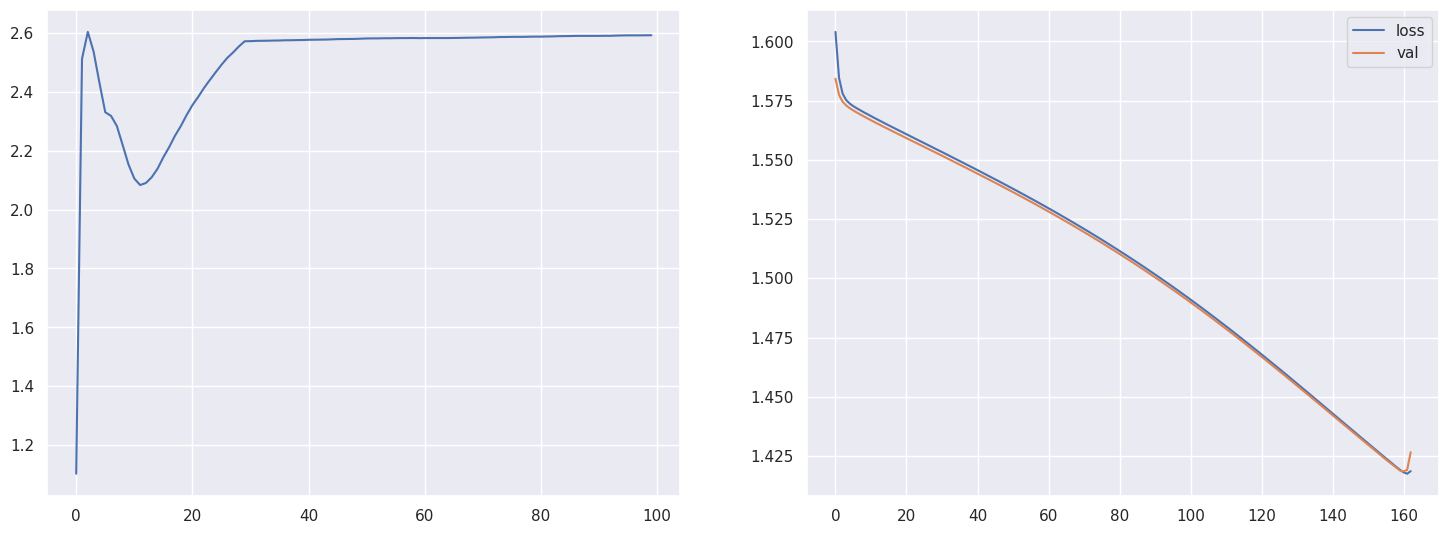

7
8
Final Training Loss: 1.363
Epoch: 299


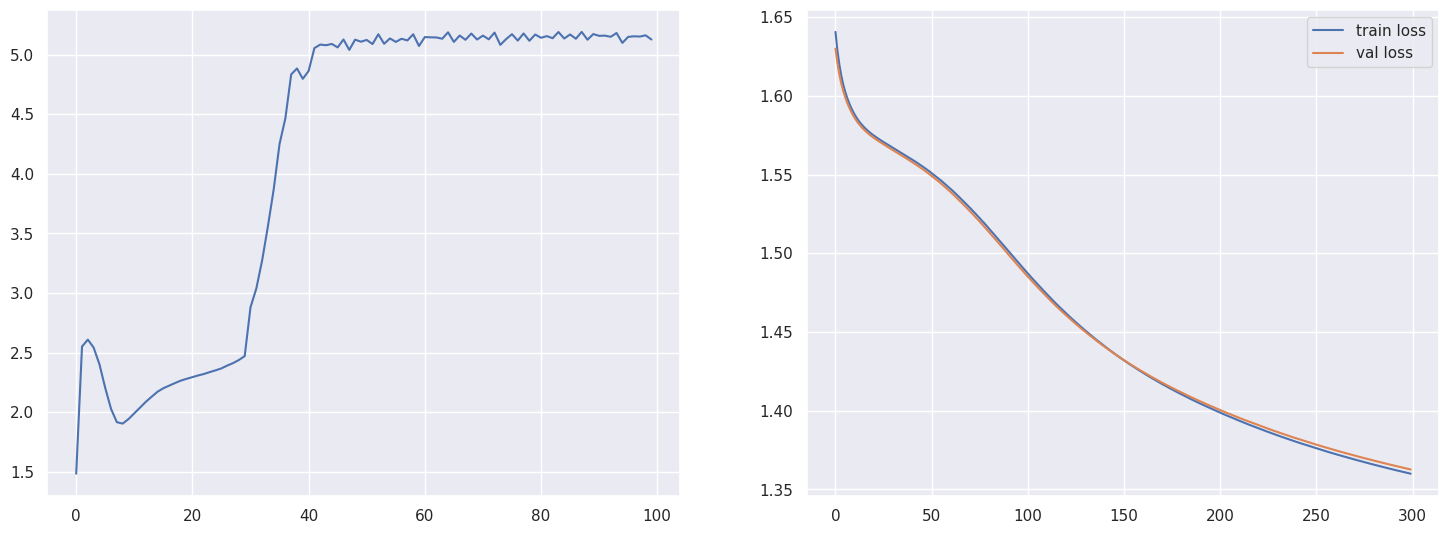

8


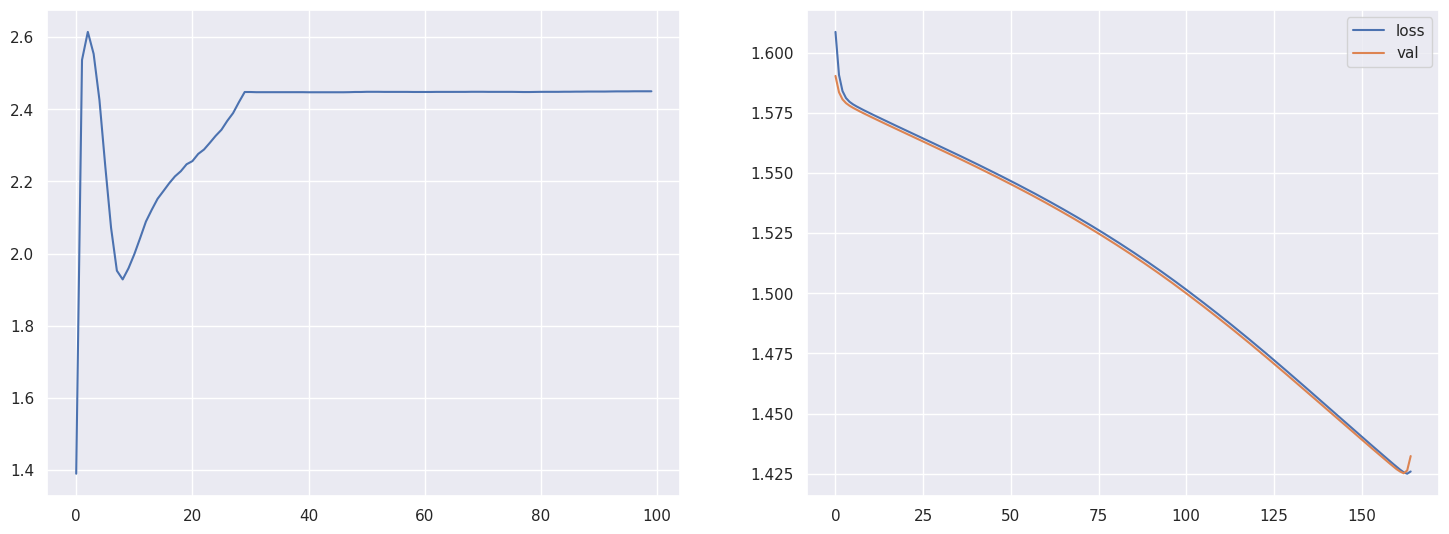

8
9
Final Training Loss: 1.374
Epoch: 206
break converge at epoch 39


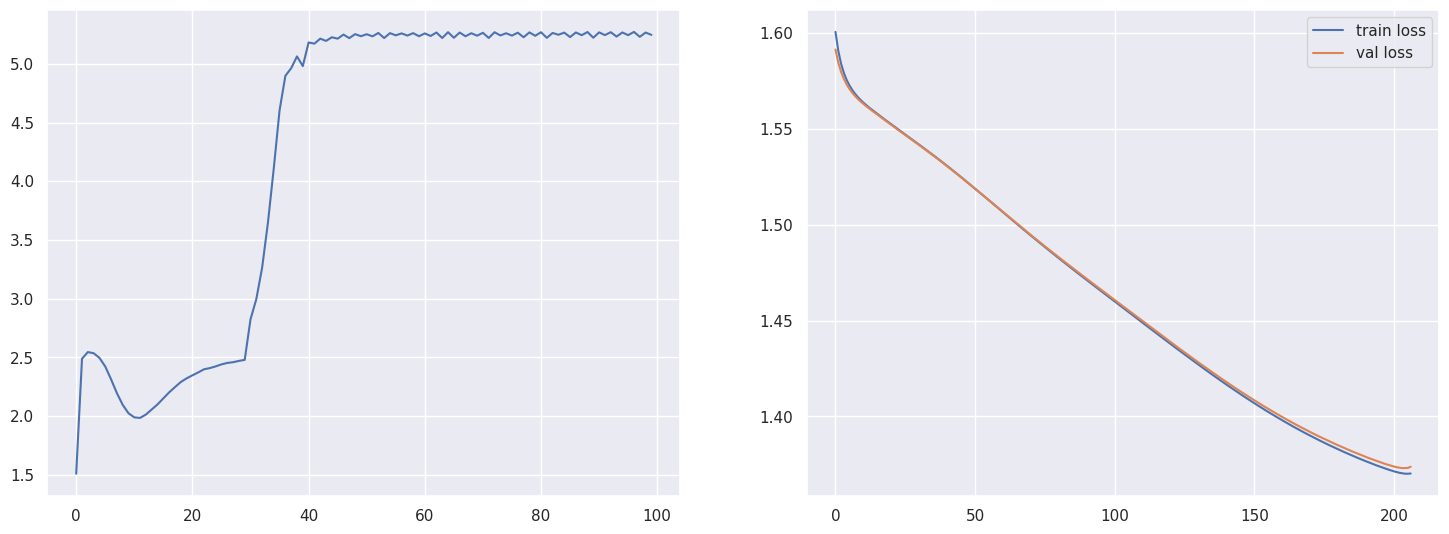

9


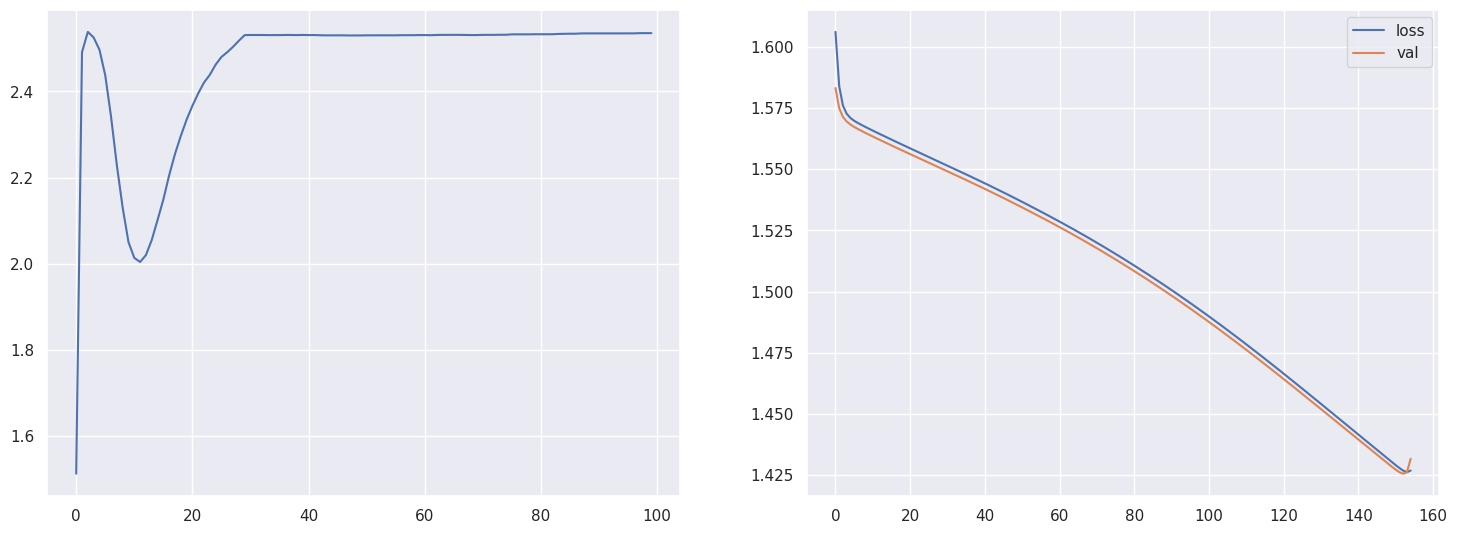

9


In [21]:
# sgd FOR prSGD


num_epoch = 300

epoch = list(range(T)) * 10

H = 30

f = 500

# for cost_coef in [0.025, 0.05, 0.075, 0.1][::-1]:
for cost_coef in [0.15, 0.1, 0.05]:
# for cost_coef in []:
    theta_cv = []
    cutoff_cv = []
    pg_cv = []
    spg_cv = []
    init_seed = 0
    
    print(cost_coef)
    
    for rep_index in range(10):
        spg_curve = StrategicGD(cost_coef=cost_coef, lr_pi=0.1, lr_prob=0.2, seed=init_seed + rep_index, dim_v=dim_v, card_u=card_u, beta=beta, trans=trans, H=H, f=f, len_seq=len_seq, num_epoch=num_epoch, T=T, n=n, n_eval=n_eval)                
        cutoff_cv.append(cutoff(cost_coef=cost_coef, seed=init_seed + rep_index, dim_v=dim_v, card_u=card_u, beta=beta, trans=trans, n_eval=n_eval))        
        theta_curve = End2endGD(cost_coef=cost_coef, lr_pi=0.1, lr_prob=0.05, seed=init_seed + rep_index, dim_v=dim_v, card_u=card_u, beta=beta, trans=trans, H=H, f=f, len_seq=len_seq, num_epoch=num_epoch, T=T, n=n, n_eval=n_eval)
        pg_curve = VanillaGD(cost_coef=cost_coef, lr_pi=0.1, seed=init_seed + rep_index, dim_v=dim_v, card_u=card_u, beta=beta, trans=trans,  T=T, n=n, n_eval=n_eval)

        spg_cv.extend(spg_curve)
        pg_cv.extend(pg_curve)
        theta_cv.extend(theta_curve)   

    
    df = pd.DataFrame({'epoch': epoch, "spg": spg_cv, "e2e": theta_cv, "vani":pg_cv})
    df.to_csv("synthetic_nov_c{}_final.csv".format(cost_coef))
    torch.save(cutoff_cv, "synthetic_cutoff_c{}_final.pkl".format(cost_coef))
    

# Generate instances

0.15
0


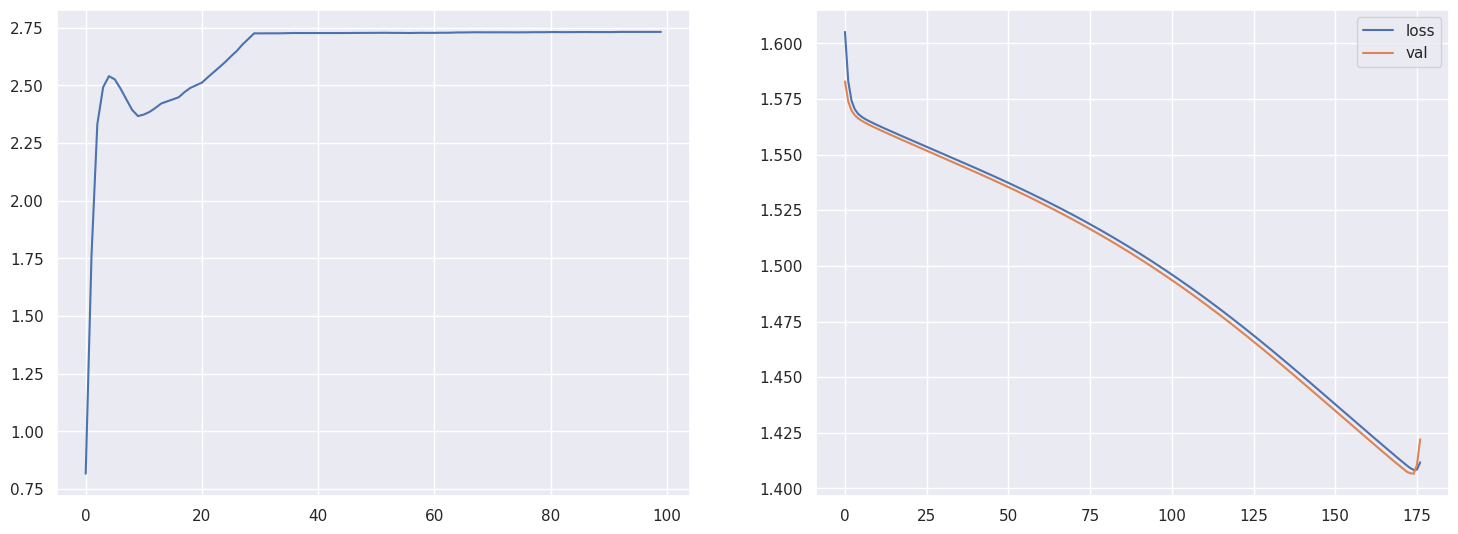

0
0.1
0


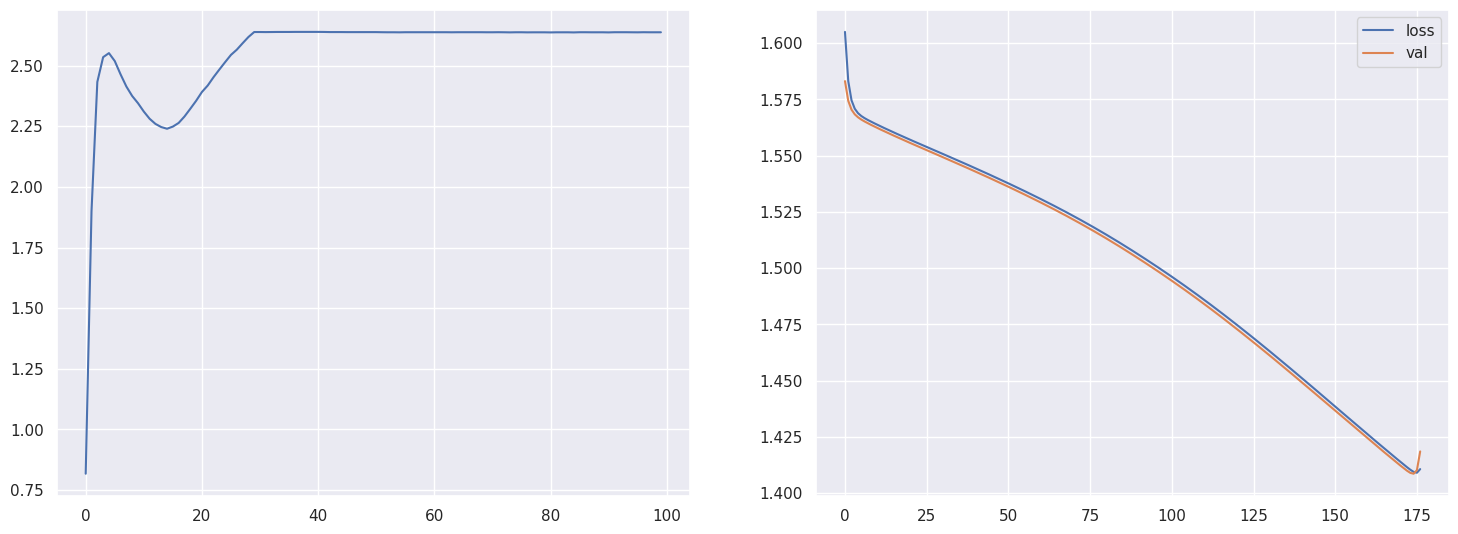

0
0.05
0


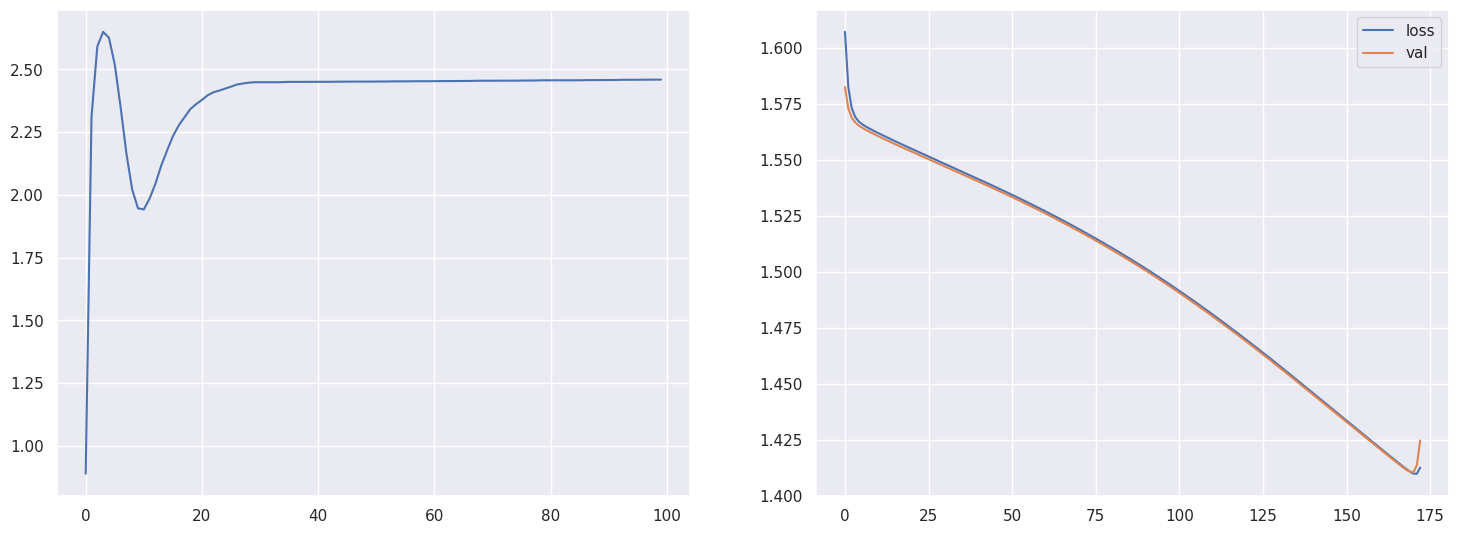

0


In [24]:


# sgd FOR prSGD


num_epoch = 300

epoch = list(range(T)) * 10

H = 30

f = 500

for cost_coef in [0.15, 0.1, 0.05]:
    theta_cv = []
    cutoff_cv = []
    pg_cv = []
    spg_cv = []
    init_seed = 0
    
    print(cost_coef)
    
    for rep_index in range(1):
        # spg_curve = StrategicGD(cost_coef=cost_coef, lr_pi=0.1, lr_prob=0.2, seed=init_seed + rep_index, dim_v=dim_v, card_u=card_u, beta=beta, trans=trans, H=H, f=f, len_seq=len_seq, num_epoch=num_epoch, T=T, n=n, n_eval=n_eval)                
        # cutoff_cv.append(cutoff(cost_coef=cost_coef, seed=init_seed + rep_index, dim_v=dim_v, card_u=card_u, beta=beta, trans=trans, n_eval=n_eval))        
        theta_curve = End2endGD(cost_coef=cost_coef, lr_pi=0.1, lr_prob=0.05, seed=init_seed + rep_index, dim_v=dim_v, card_u=card_u, beta=beta, trans=trans, H=H, f=f, len_seq=len_seq, num_epoch=num_epoch, T=T, n=n, n_eval=n_eval)
        pg_curve = VanillaGD(cost_coef=cost_coef, lr_pi=0.1, seed=init_seed + rep_index, dim_v=dim_v, card_u=card_u, beta=beta, trans=trans,  T=T, n=n, n_eval=n_eval)


    
    

0.1
0
Final Training Loss: 1.314
Epoch: 299


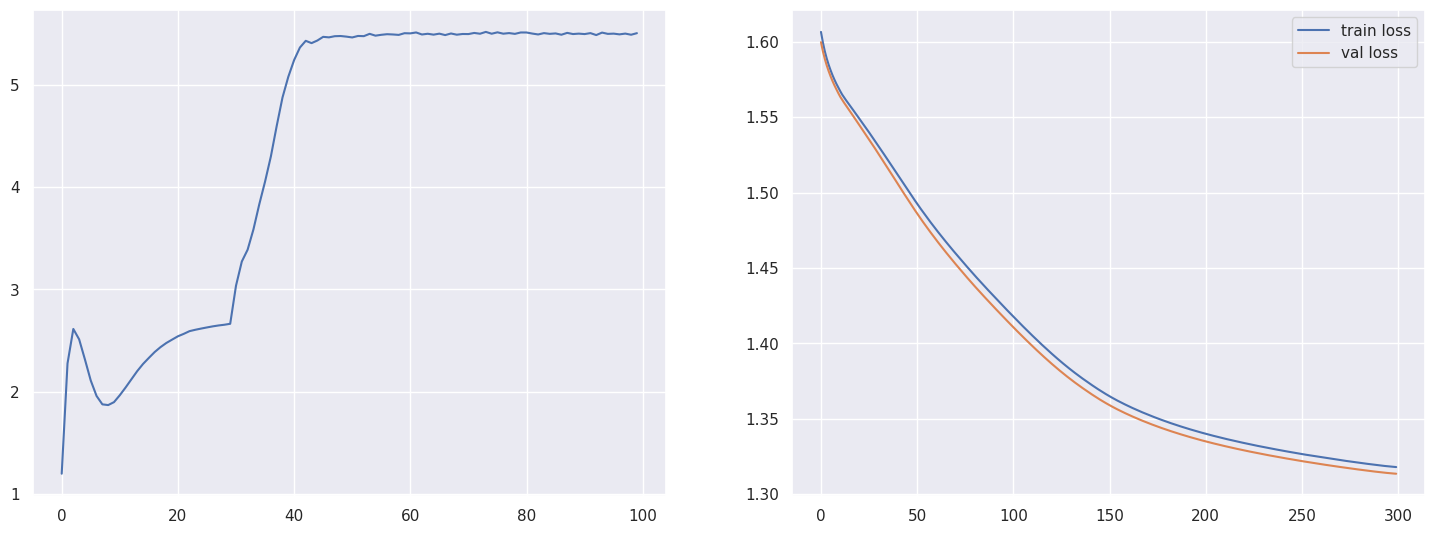

0


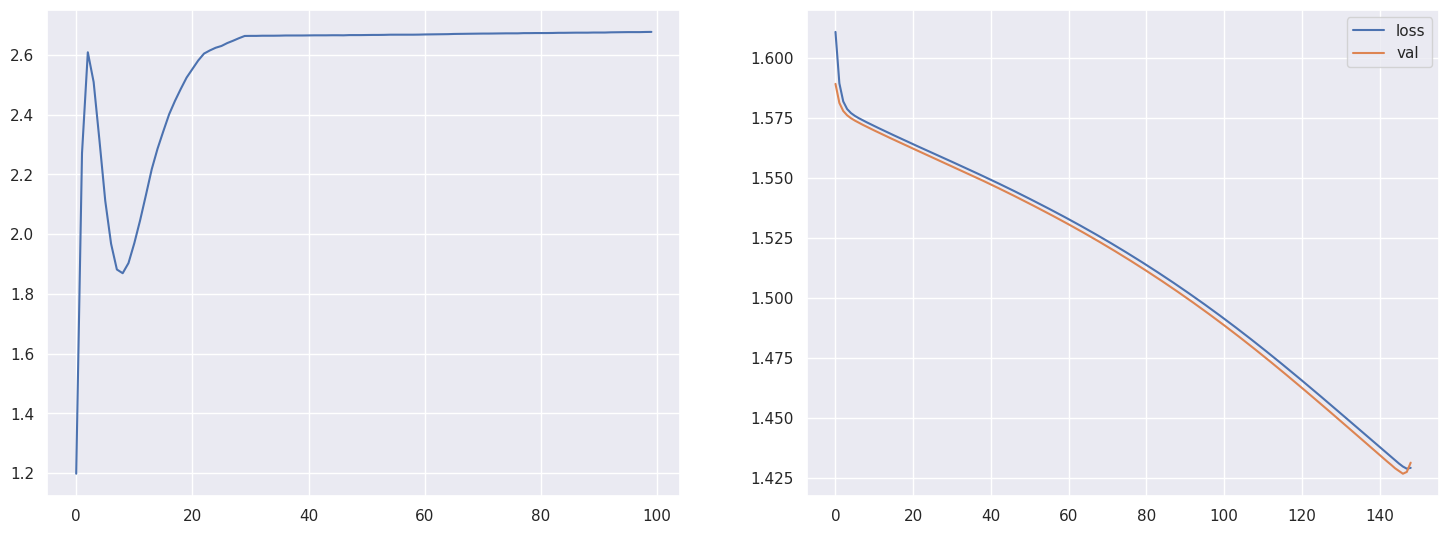

In [13]:


# sgd FOR prSGD


num_epoch = 300

epoch = list(range(T)) * 10

H = 30
f = 500

for cost_coef in [0.1]:
    init_seed = 0
    print(cost_coef)
    
    for rep_index in range(1):
        spg_curve = StrategicGD(cost_coef=cost_coef, lr_pi=0.1, lr_prob=0.2, seed=init_seed + rep_index, dim_v=dim_v, card_u=card_u, beta=beta, trans=trans, H=H, f=f, len_seq=len_seq, num_epoch=num_epoch, T=T, n=n, n_eval=n_eval)                
        theta_curve = End2endGD(cost_coef=cost_coef, lr_pi=0.1, lr_prob=0.05, seed=init_seed + rep_index, dim_v=dim_v, card_u=card_u, beta=beta, trans=trans, H=H, f=f, len_seq=len_seq, num_epoch=num_epoch, T=T, n=n, n_eval=n_eval)


    
    